This notebook demonstrates performance of tSSA model. It also saves/loads some data and figures. Model's parameters can be changed in the corresponding sections here.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [5]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

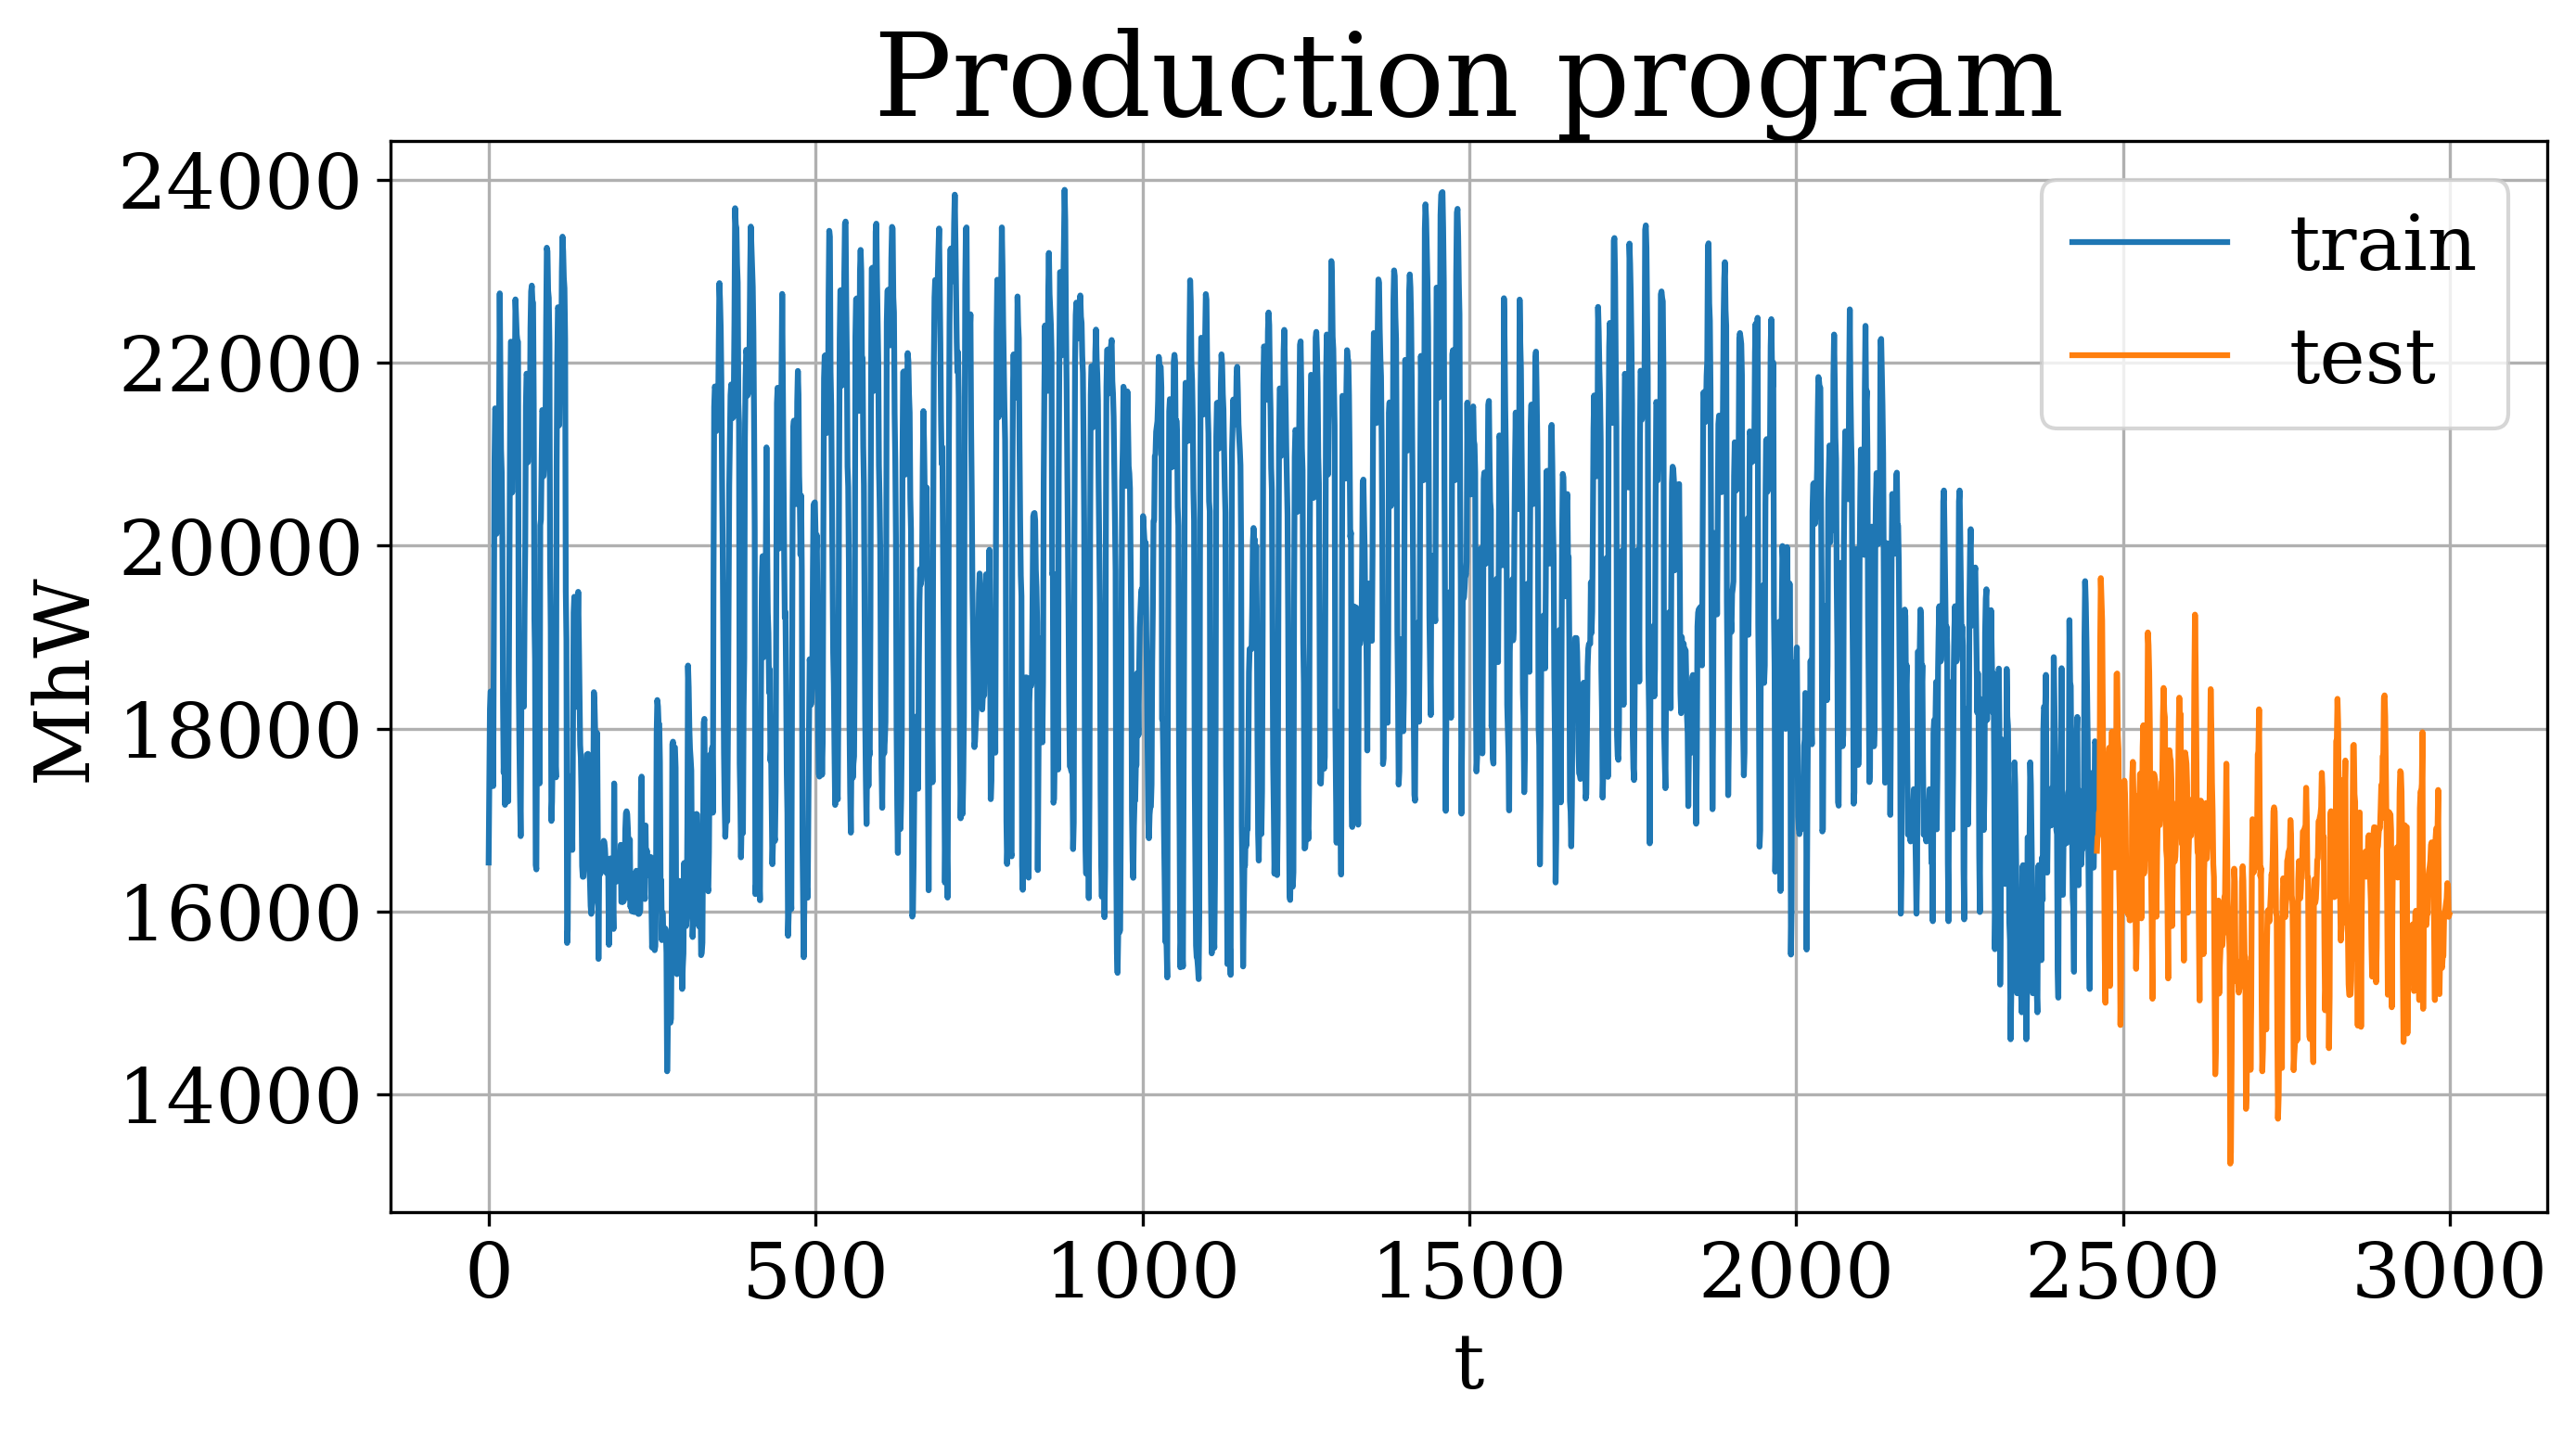

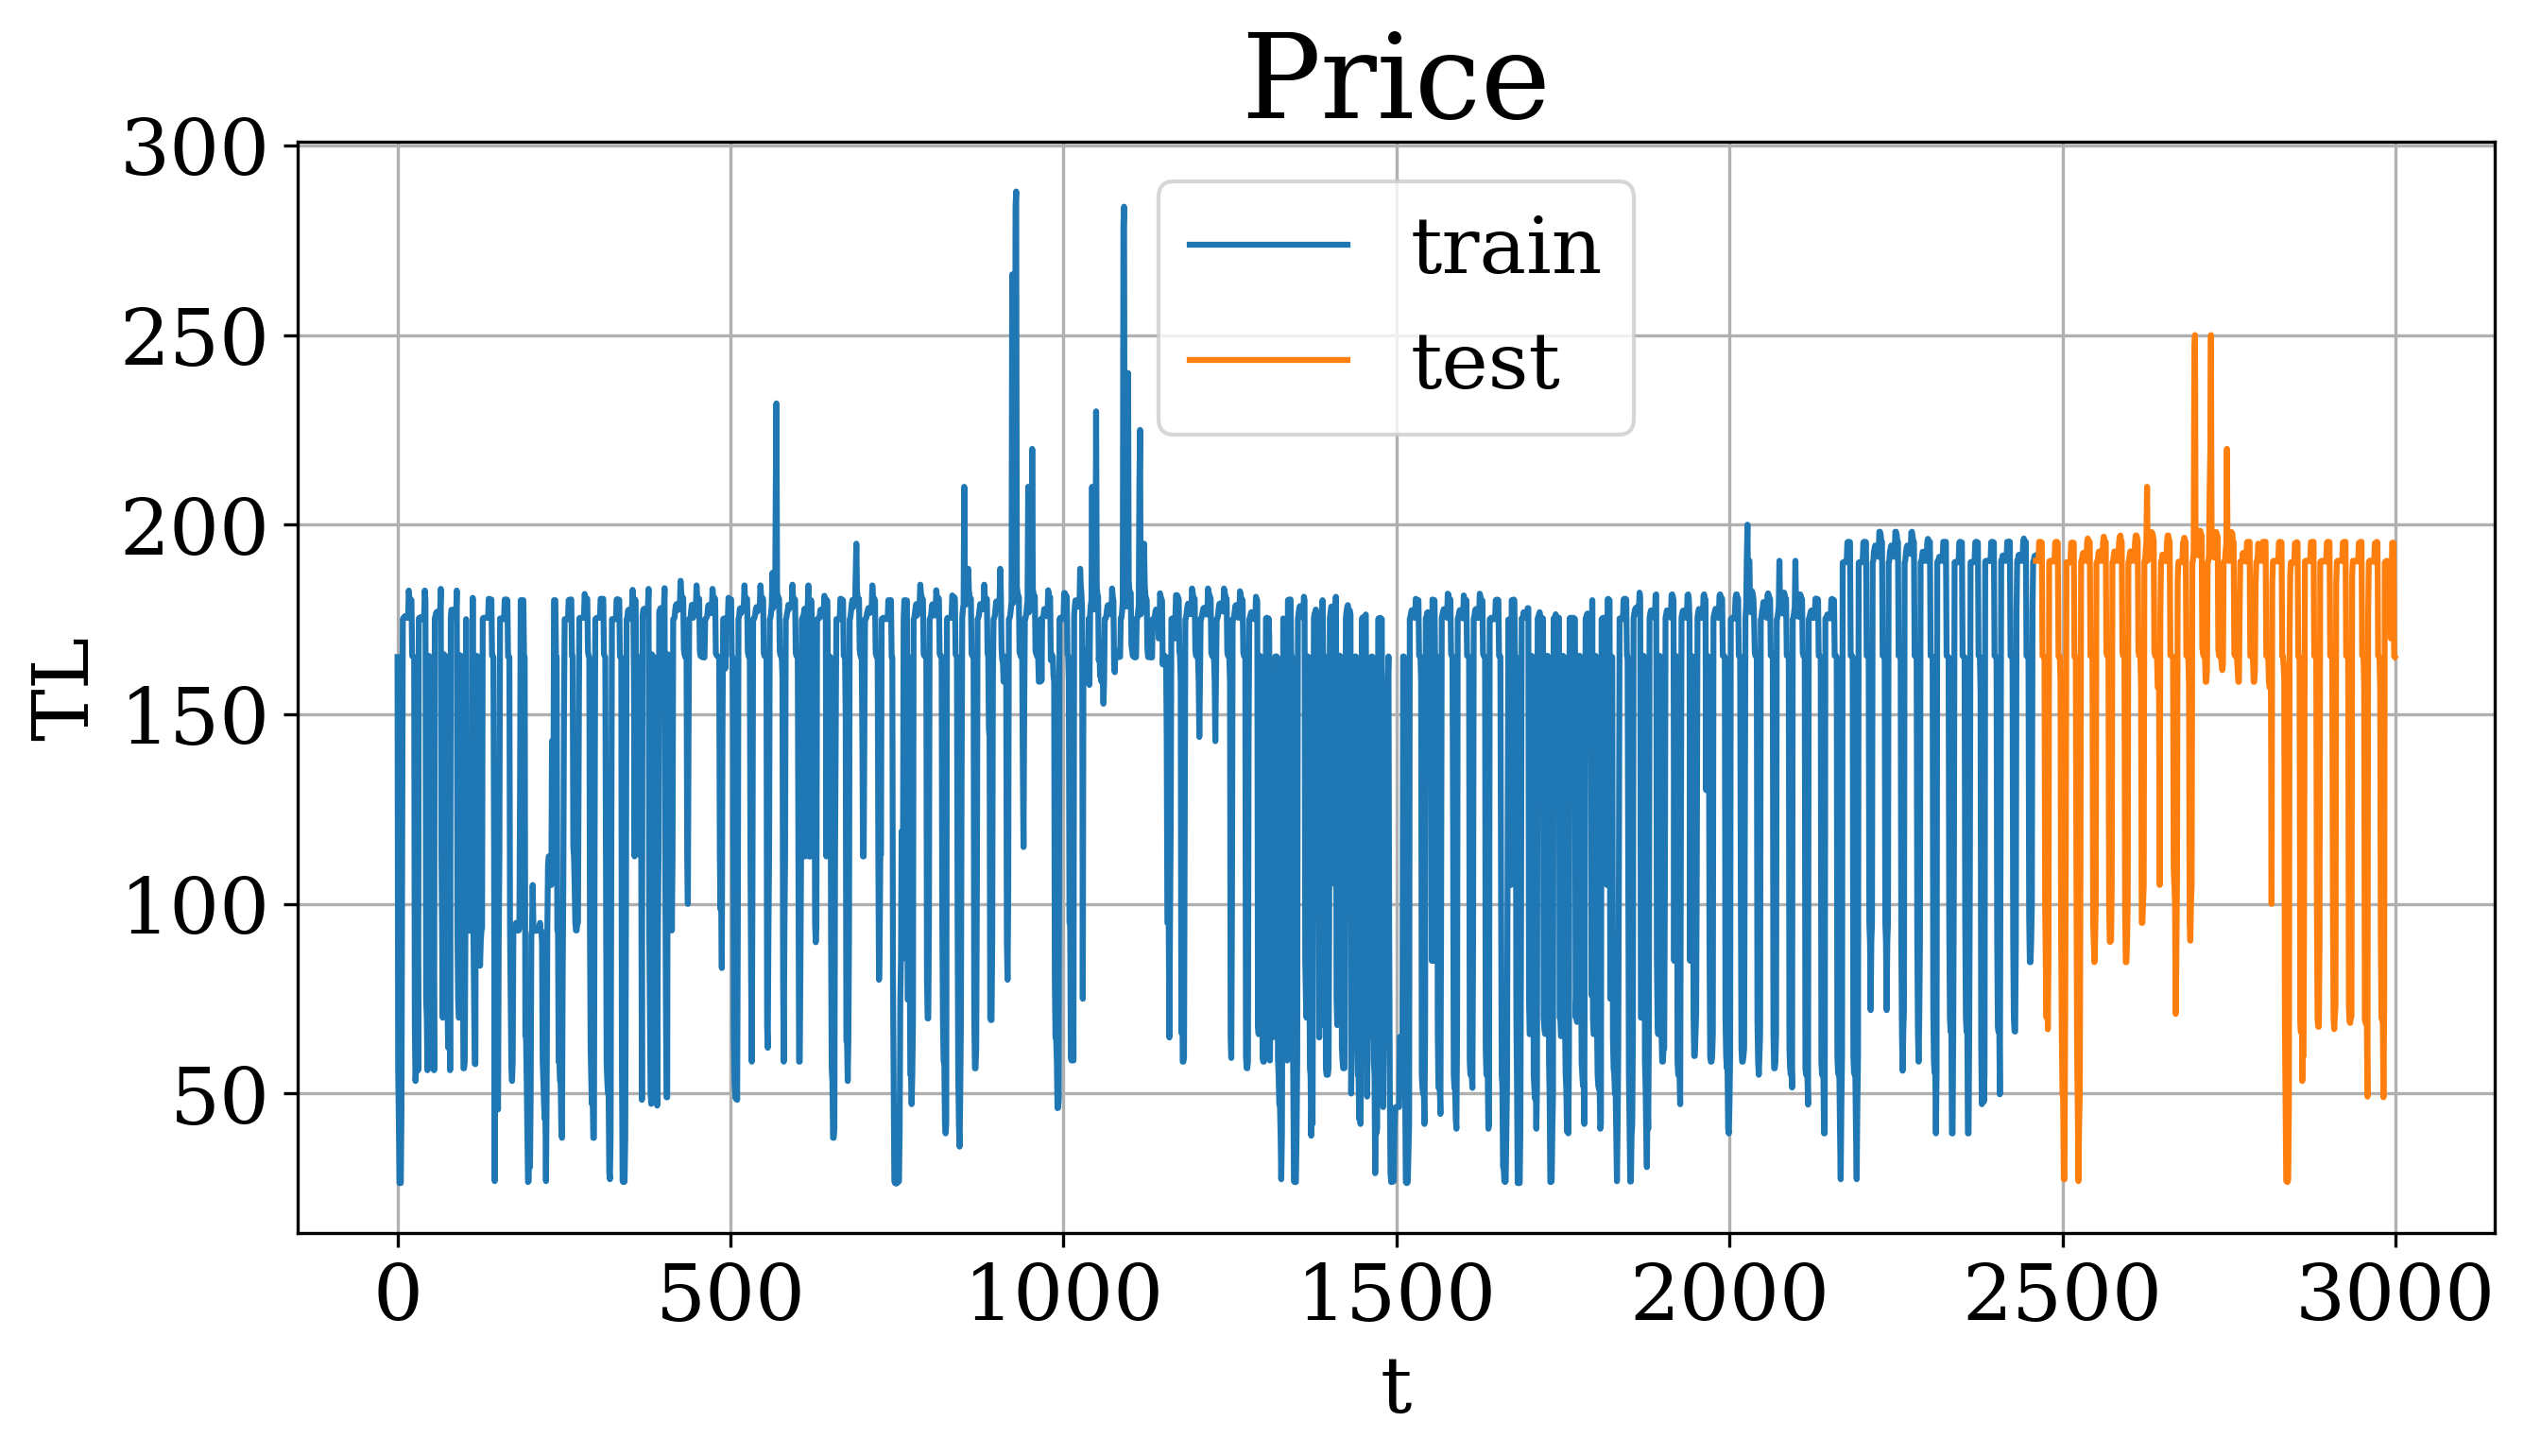

In [7]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

        if i == 0:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Production.png", format='png')
        if i == 1:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Price.png", format='png')

## Global method parameters

In [7]:
# aka L parameter
ssa_window_size = 500

cpd_rank = 10

# parameter for detereministic behaviour of tSSA
random_state = 42

## tSSA fitting

In [ ]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

In [8]:
# load model if it already exists
if pathlib.Path(f'./saved_model/cpd_rank_{cpd_rank}.pkl').exists():
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'rb') as f:
        t_ssa_obj = pickle.load(f)
else:
    t_ssa_obj = t_SSA(ssa_window_size, train_data.T, cpd_rank)

    # make svd for common matrix, extract factors and singular values
    t_ssa_obj.decompose_tt(random_state=random_state)

    # save model
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'wb') as f:
        pickle.dump(t_ssa_obj, f)

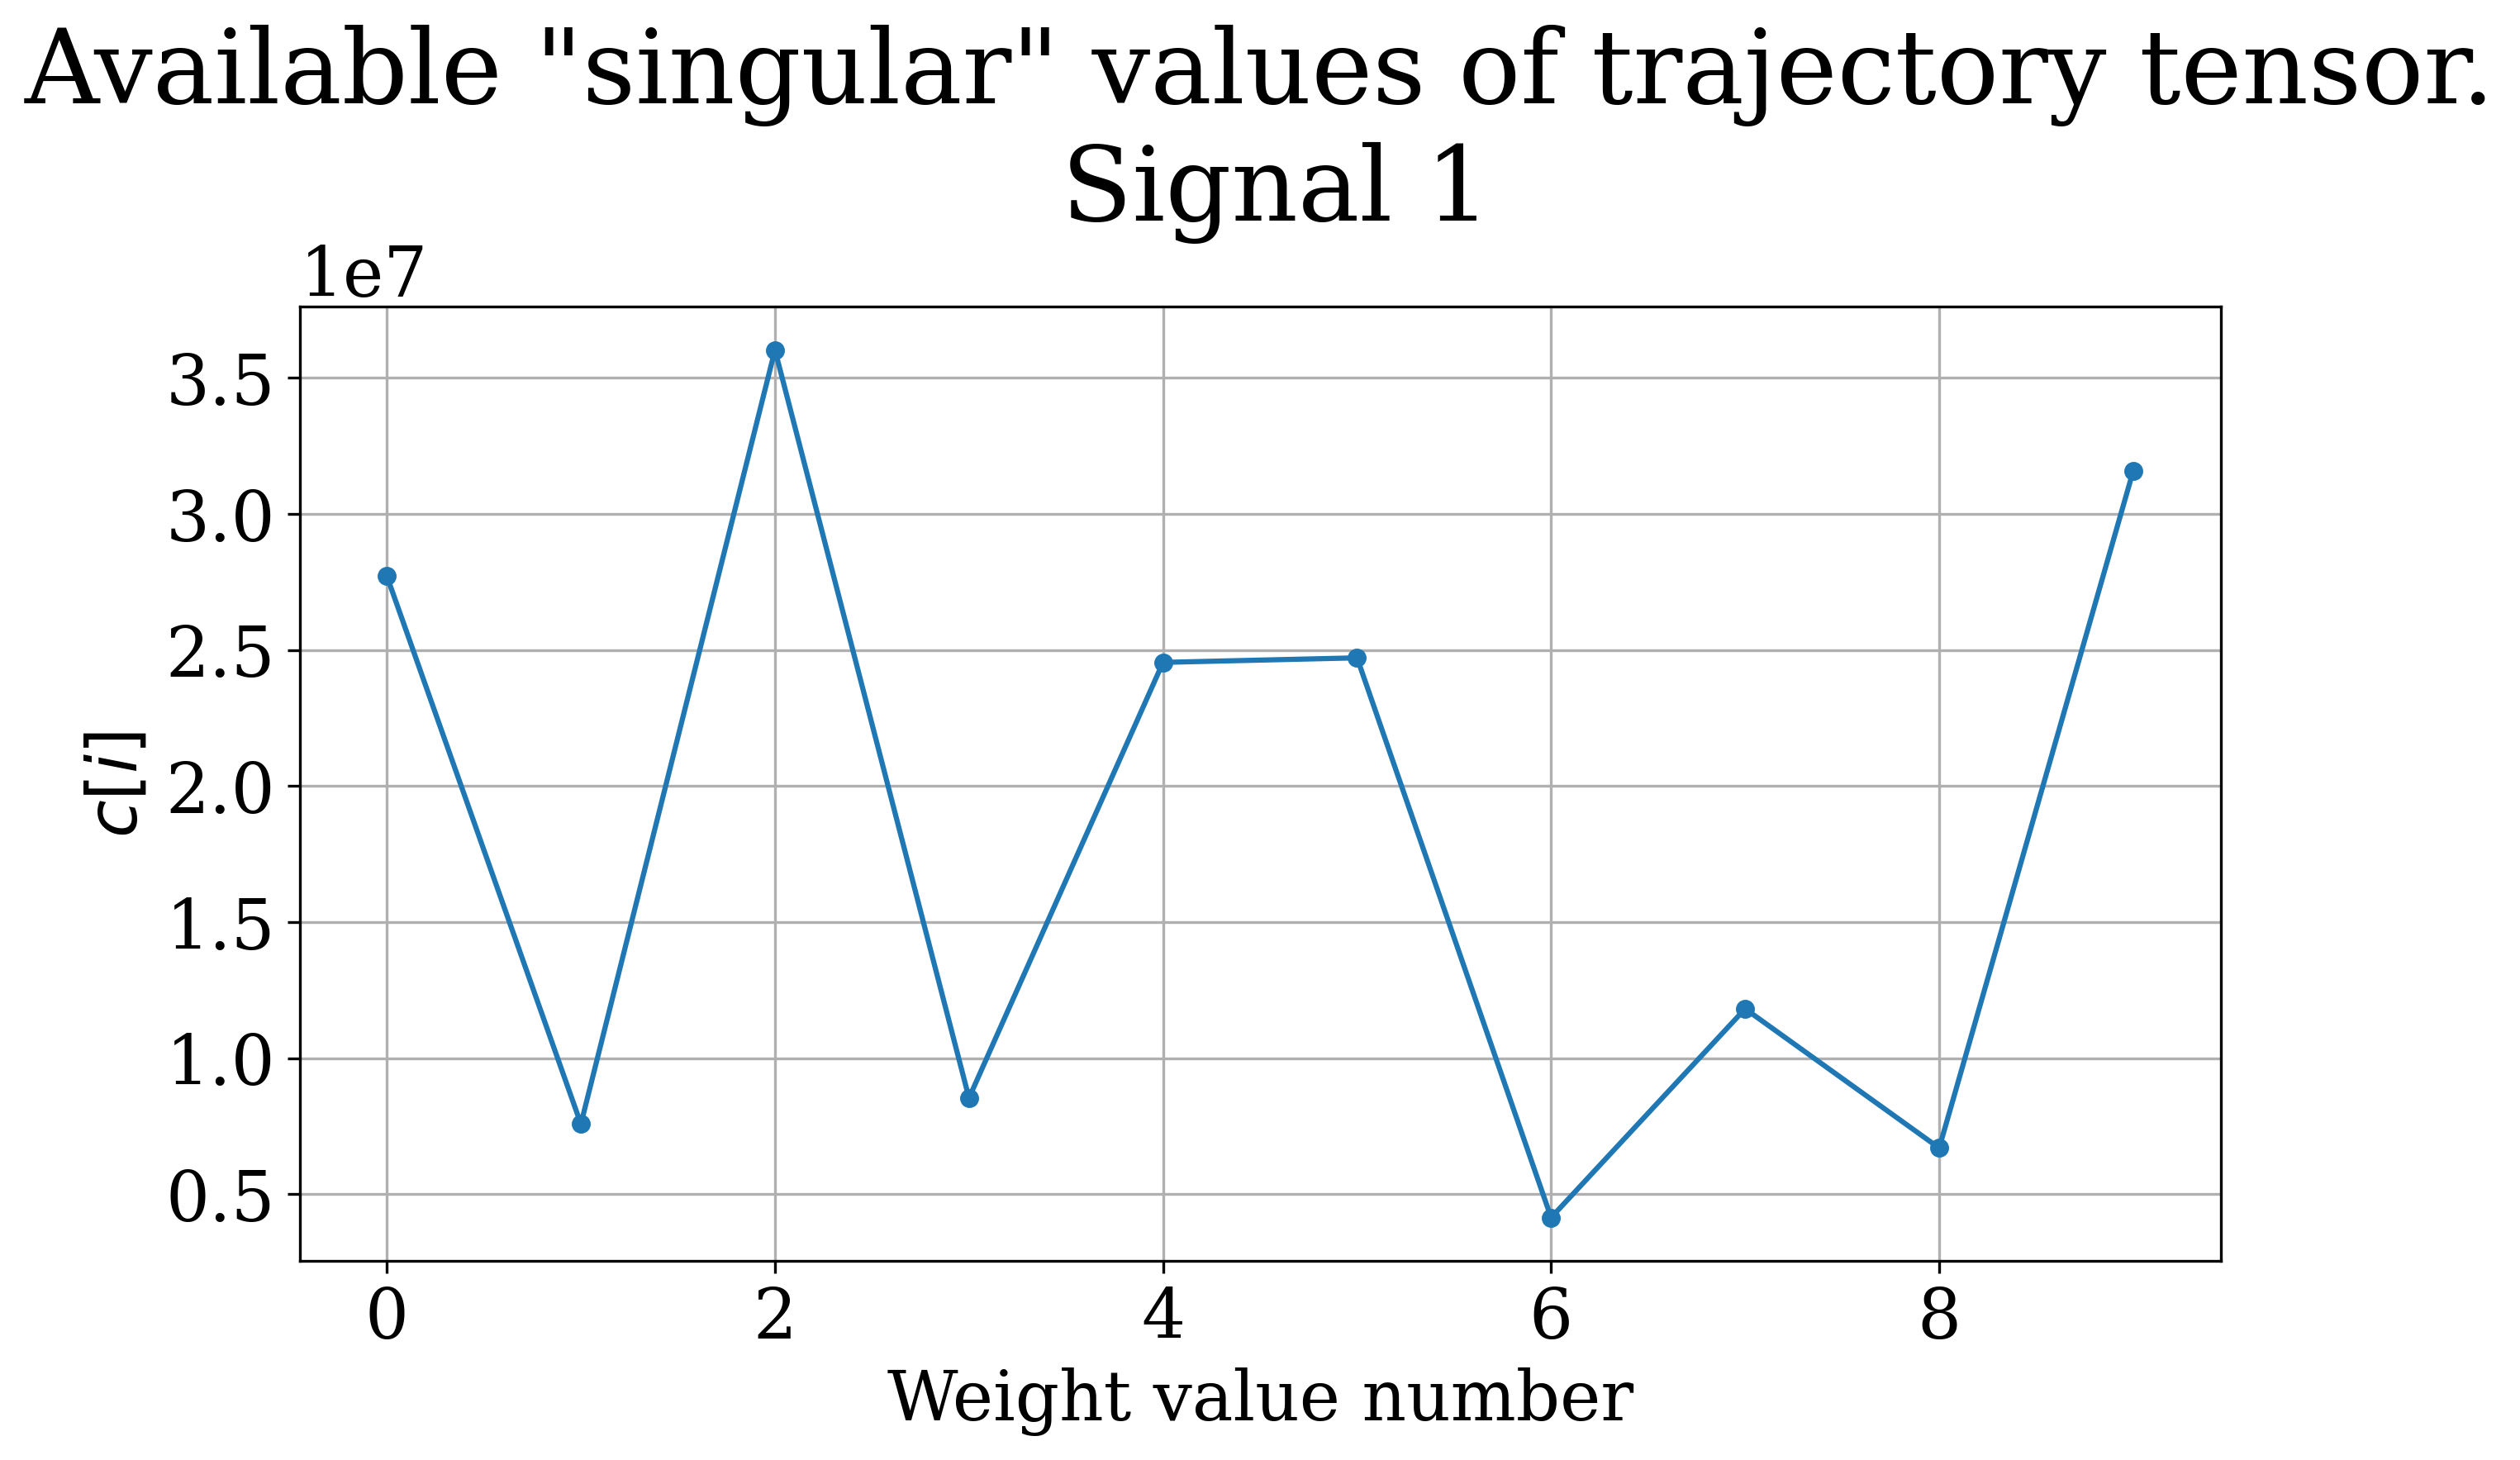

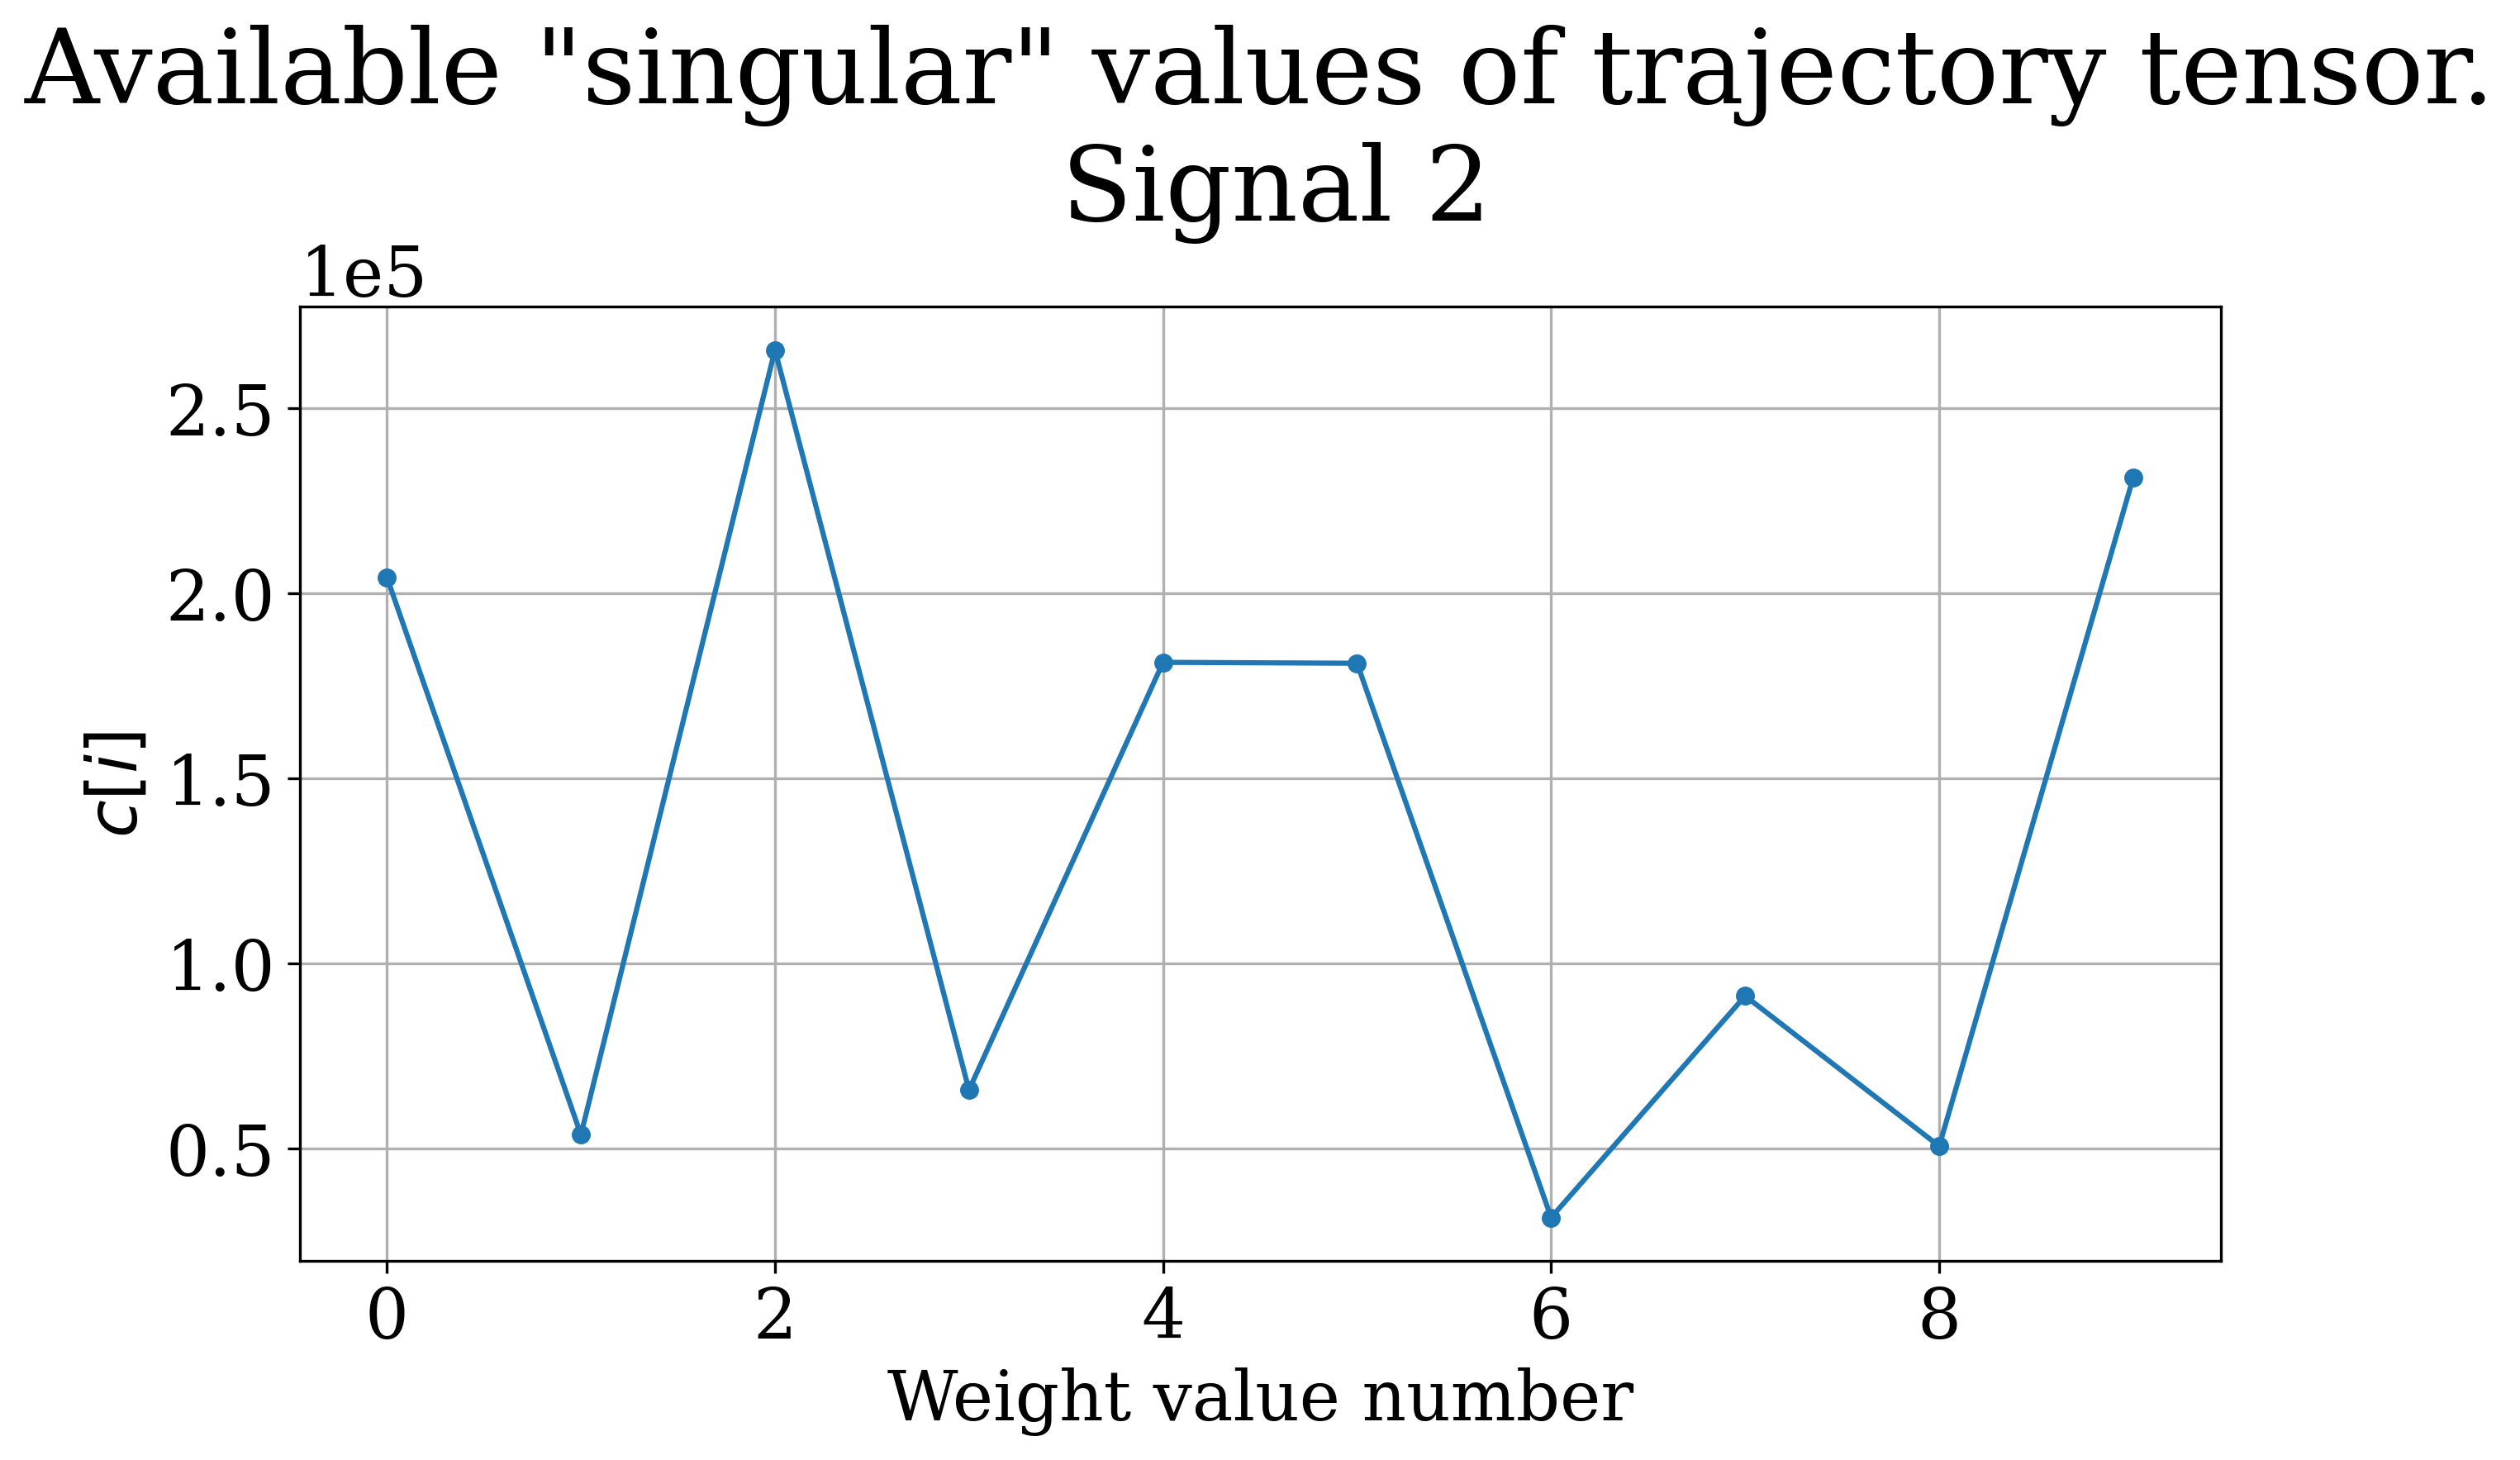

In [9]:
# have a look on "singular" values
for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(t_ssa_obj.weights[i], marker='.')

        ax.grid(True)
        ax.set_title(f'Available "singular" values of trajectory tensor.\n Signal {i + 1}')
        ax.set_xlabel('Weight value number')
        ax.set_ylabel(r'$c[i]$')
        ax.ticklabel_format(style='sci', scilimits=(0, 0))

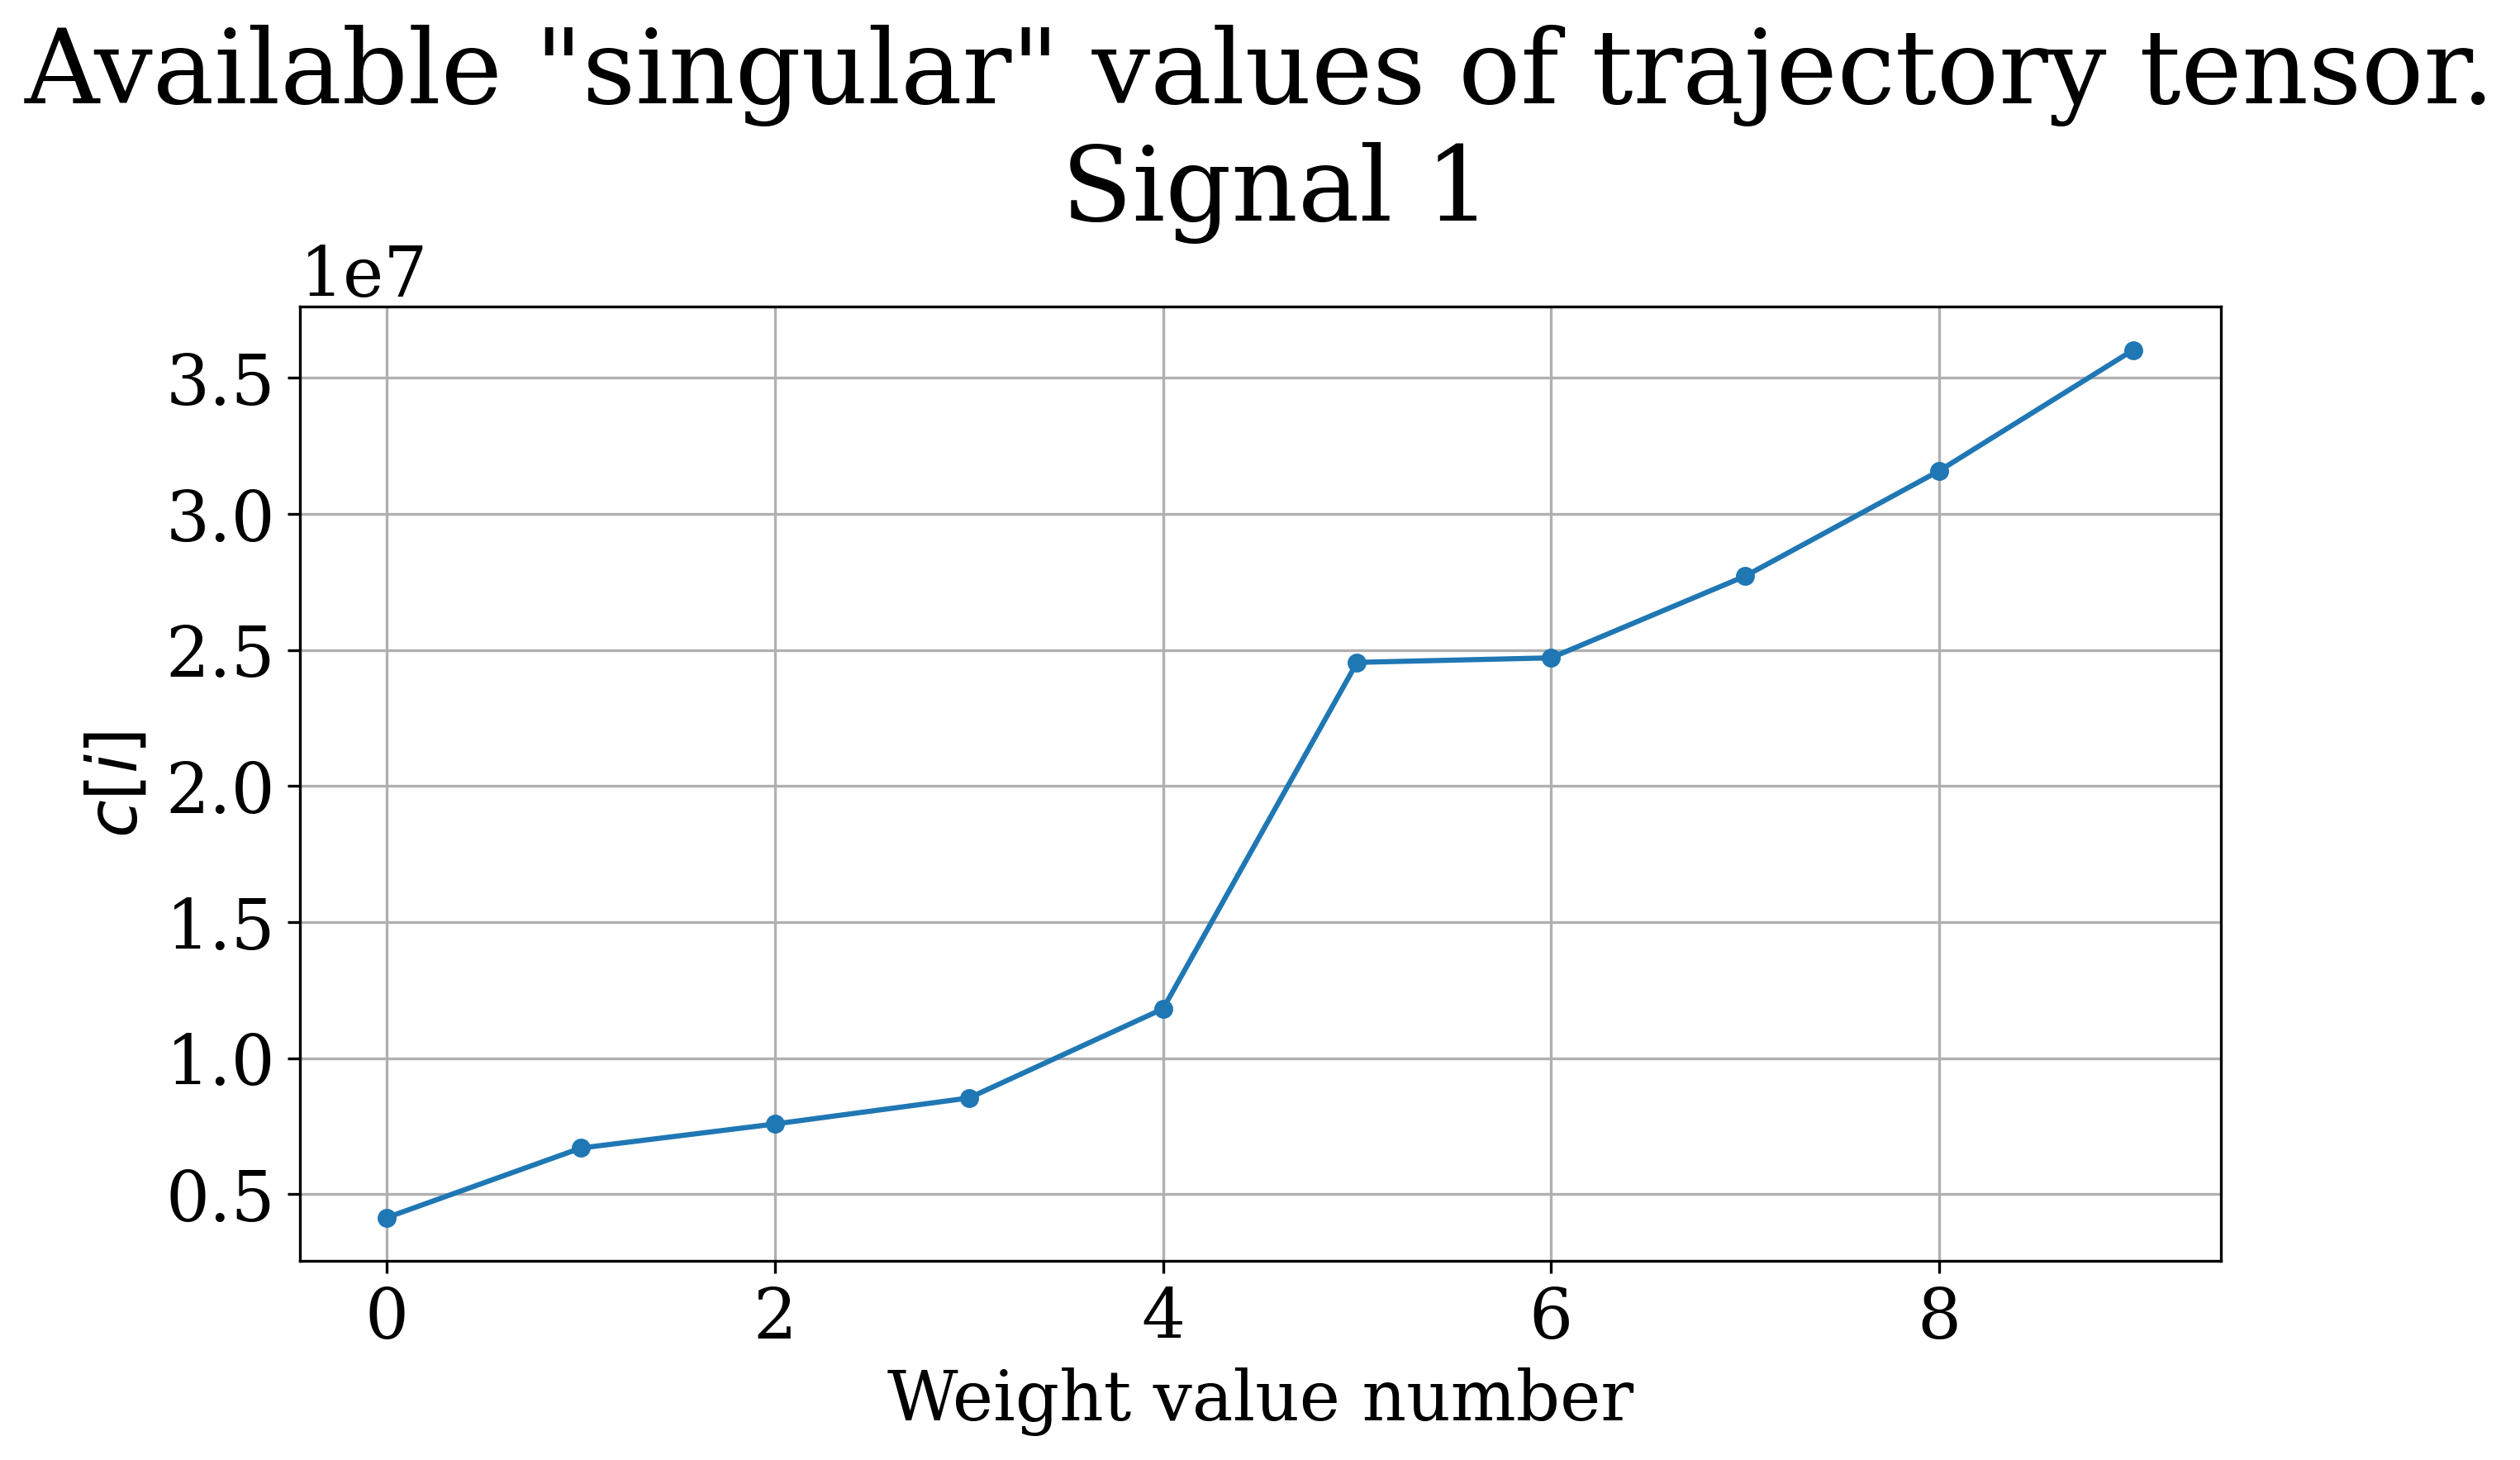

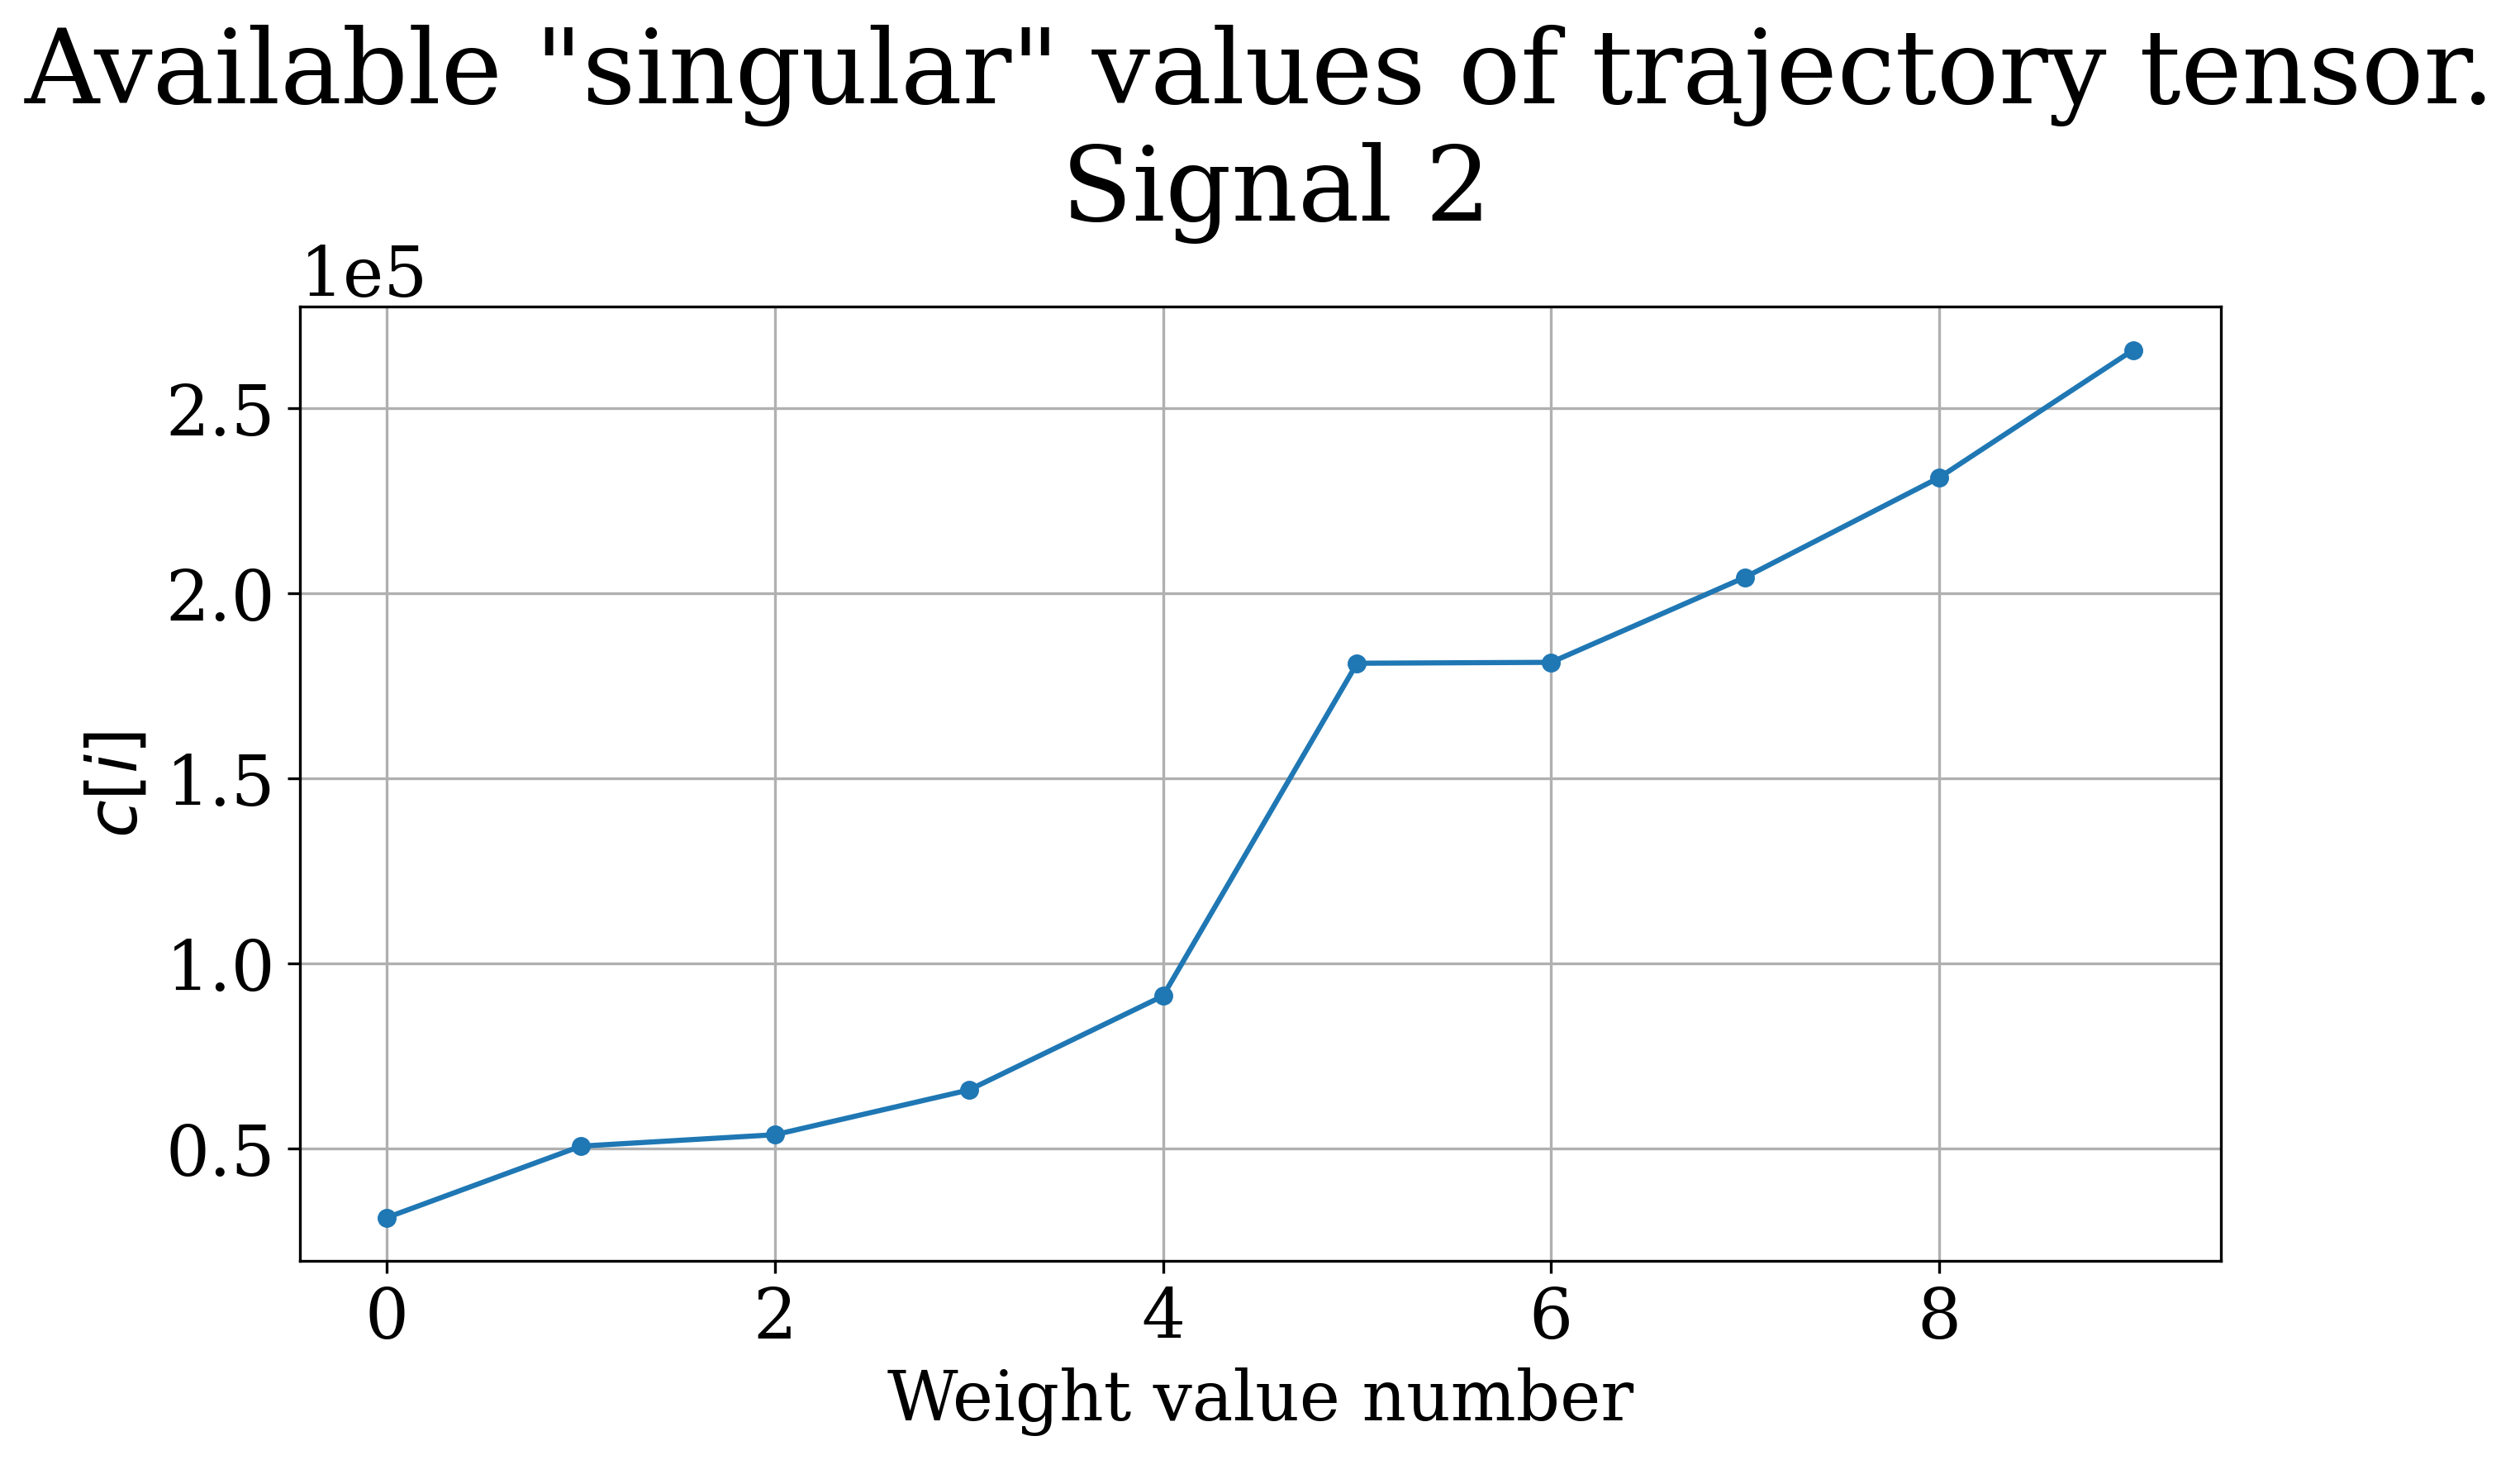

In [10]:
# plot them in descending order (in absolute values)

weights_abs_ordered = np.sort(np.abs(t_ssa_obj.weights), axis=1)

for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(weights_abs_ordered[i], marker='.')

        ax.grid(True)
        ax.set_title(f'Available "singular" values of trajectory tensor.\n Signal {i + 1}')
        ax.set_xlabel('Weight value number')
        ax.set_ylabel(r'$c[i]$')
        ax.ticklabel_format(style='sci', scilimits=(0, 0))

Now we can dispose some factors if they have small weights (or relatively small)

In [11]:
pass

## Decomposition

Utilizing dichotomy method

In [9]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

In [13]:
# make directory for figures
pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}').mkdir(parents=True, exist_ok=True)

# make directory for groupings
pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}').mkdir(parents=True, exist_ok=True)

In [10]:
def FitAndDescribe(groups: list):
    """fit tssa object with grouping, print hankel residuals, plot signal's components

    Args:
        groups (list): 
    Returns: components figures
    """
    for i in range(train_data.shape[1]):
        t_ssa_obj.set_factors_grouping(groups[i], i)

    comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

    # view relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'Group for {sig_names[i]}: {groups[i]}')
        print(f'Rel hankel. errors for {sig_names[i]}\n{hank_resid_rel[i].tolist()}\nMean = {np.mean(hank_resid_rel[i])}\n')

    figs_container = []

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))
            figs_container.append(fig)
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=20)
            fig.supxlabel('$t$', fontsize=20)
            fig.suptitle(f'{sig_names[i]}', fontsize=30)
    
    return figs_container

### Use precomputed groupings

Group for Production program: [[0, 1, 2, 3, 4, 5, 7, 8, 9], [6]]
Rel hankel. errors for Production program
[0.184756619433969, 0.9148464609754414]
Mean = 0.5498015402047052

Group for Price: [[0, 1, 2, 3, 4, 5, 7, 8, 9], [6]]
Rel hankel. errors for Price
[0.19179038602877782, 0.9148464348758291]
Mean = 0.5533184104523035



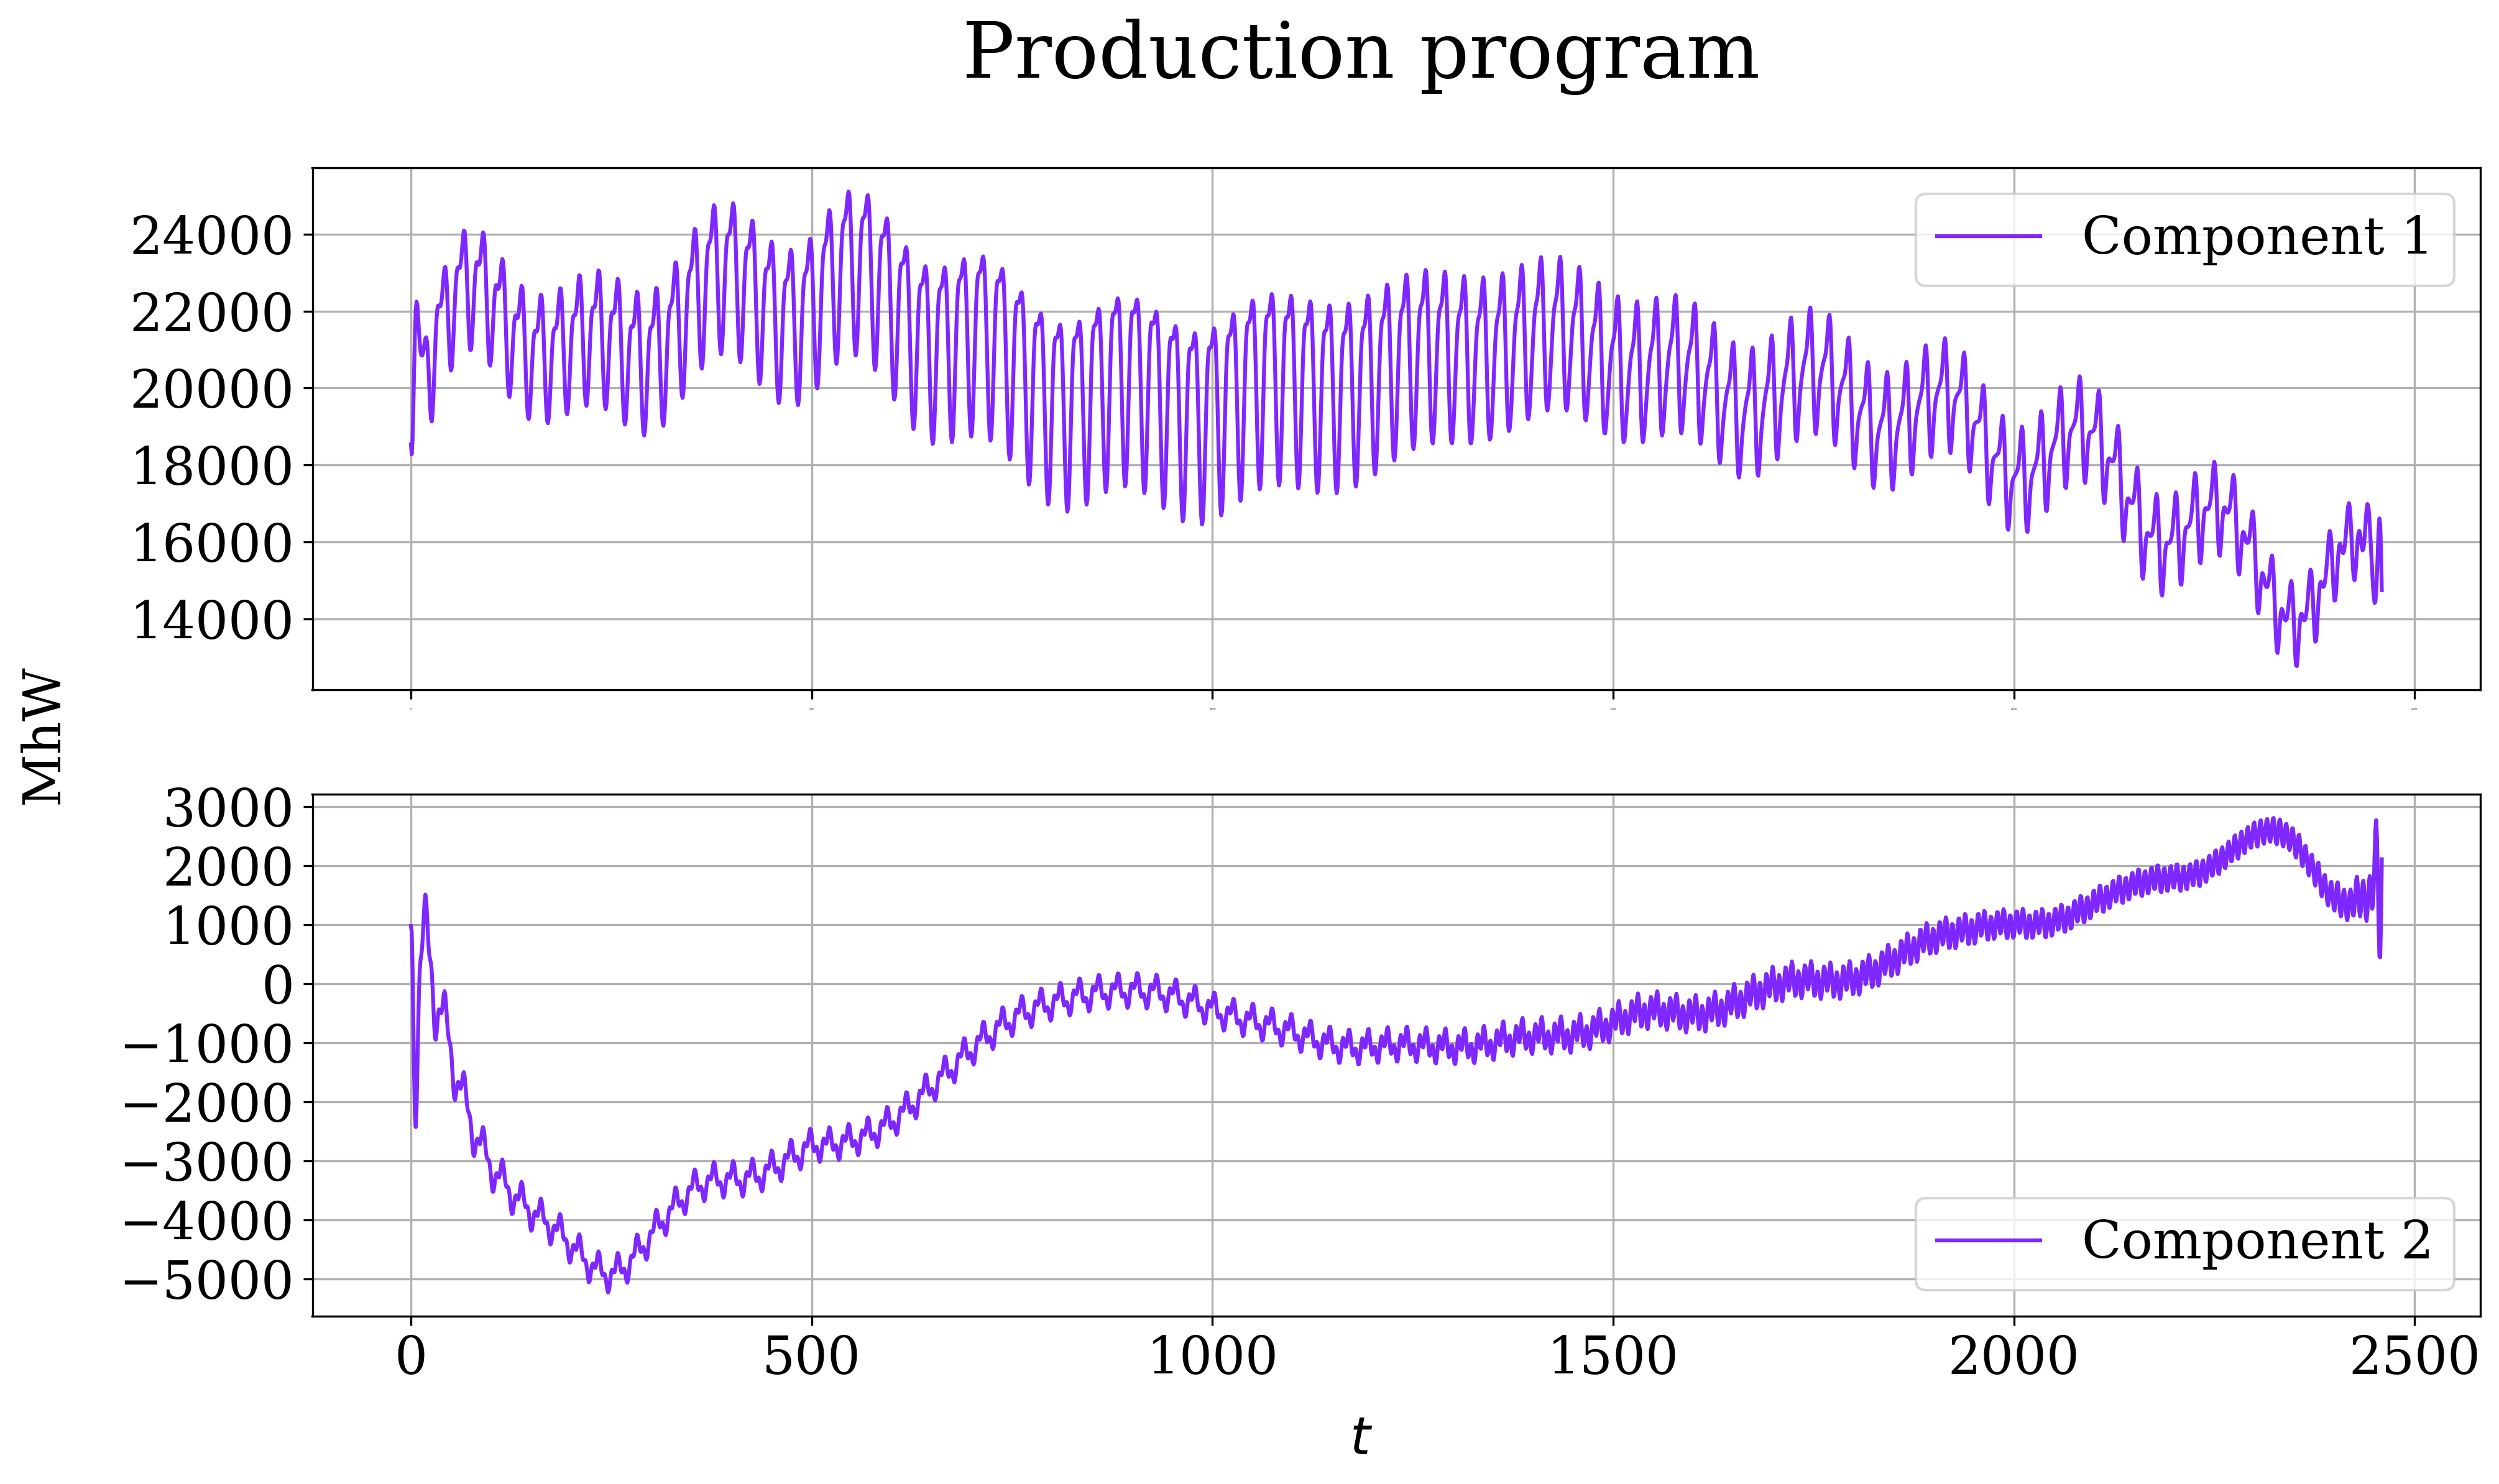

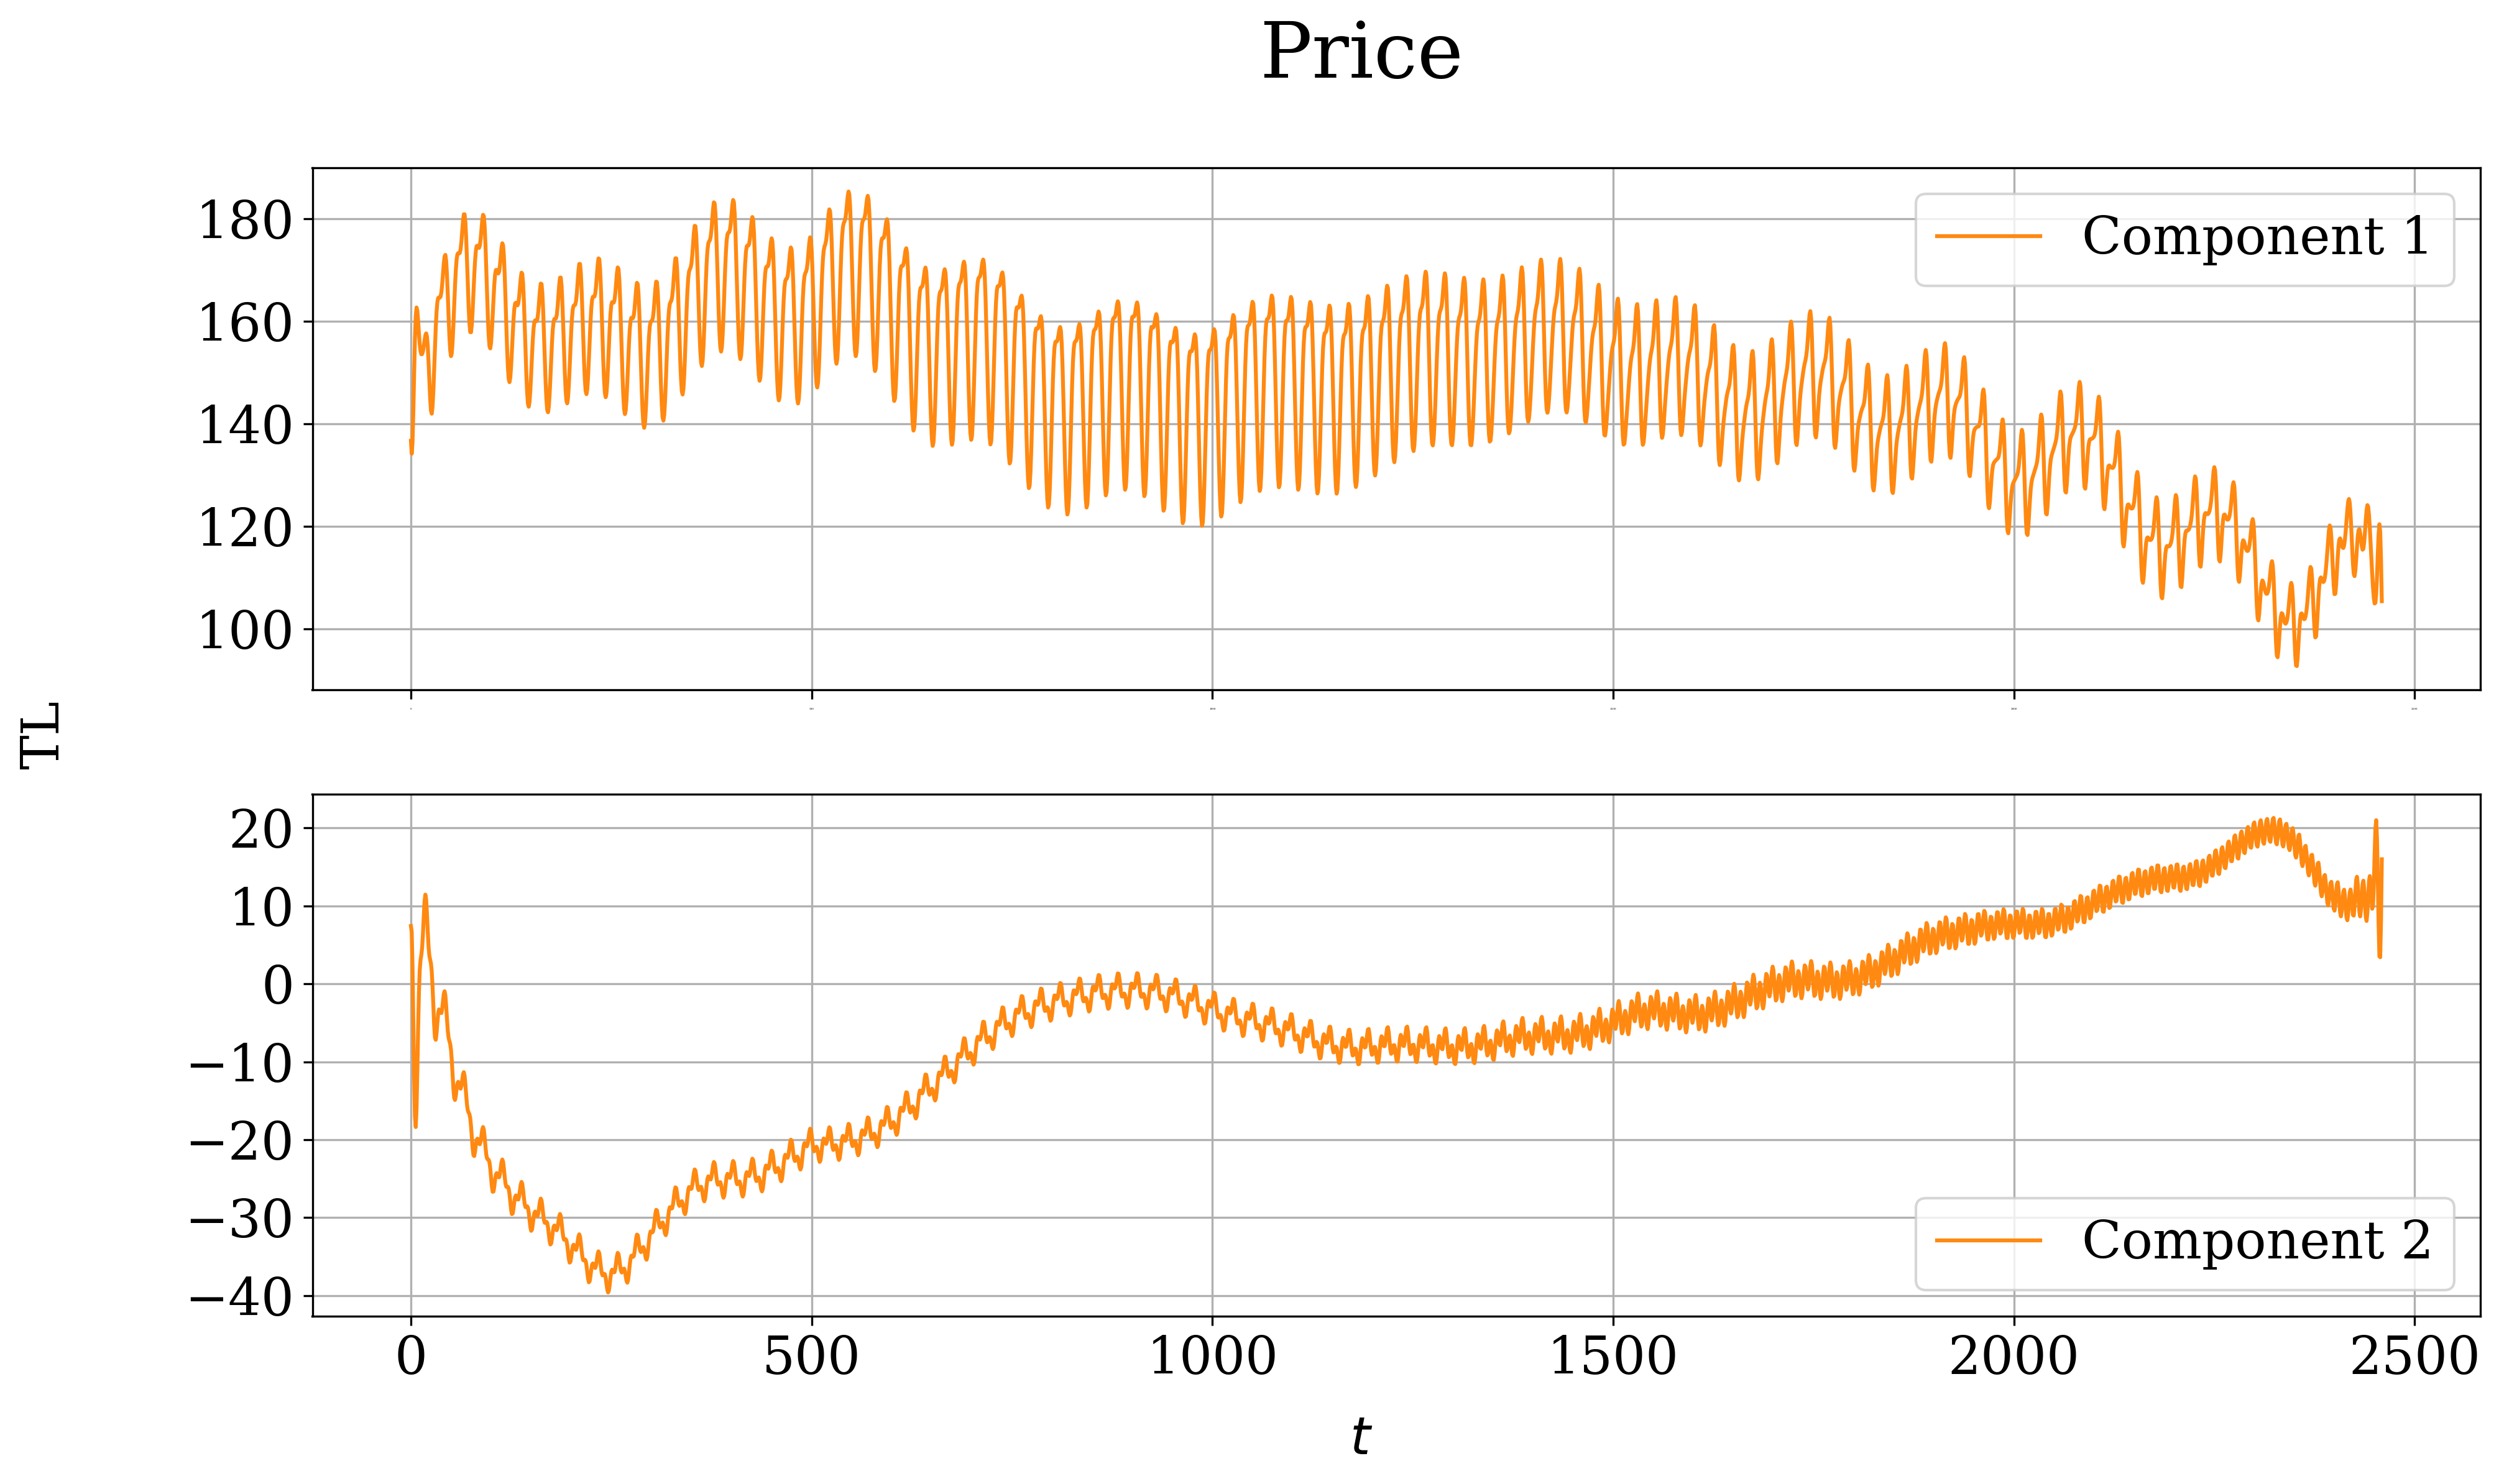

In [11]:
# enter existing group id or leave it None
existing_group_id = 3

if pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl').exists():
    with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl', 'rb') as f:
        dichy_groups = pickle.load(f)

    # use grouping and obtain decomposition results
    component_figs = FitAndDescribe(dichy_groups)
    # may safe
    ...
else:
    print('No saved grouping')

### Disect existing grouping or build new

In [12]:
# flag controlling execution of this section
want_to_disect = False

In [13]:
# creating grouping generator
if want_to_disect:
    # enter group id to further disect or None
    existing_group_id = 1

    # load initial grouping
    if pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl').exists():
        with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl', 'rb') as f:
            init_dichy_groups = pickle.load(f)
    # go from the start
    else:
        init_dichy_groups = None

    # create grouping generator
    DichPartitionGenerator = NextDichotomyPartition(t_ssa_obj, init_dichy_groups)

In [14]:
# initialzing generator
if want_to_disect:
    # case: we build grouping from the start
    if init_dichy_groups is None:
        dichy_groups, dichy_hankel_resids = next(DichPartitionGenerator)

        # use our grouping and obtain decomposition results
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_1').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_1/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )
    else:
        # we just initialize our generator
        next(DichPartitionGenerator)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Group for Production program: [[0, 2, 4, 5, 7, 9], [1], [3, 8], [6]]
Rel hankel. errors for Production program
[0.39729895363370776, 0.9737517885077661, 0.9262986366278051, 0.9148464609754414]
Mean = 0.8030489599361801

Group for Price: [[0, 2, 4, 5, 7, 9], [1], [3, 8], [6]]
Rel hankel. errors for Price
[0.39099354790627733, 0.9737516653647769, 0.9286489097557727, 0.9148464348758291]
Mean = 0.802060139475664



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


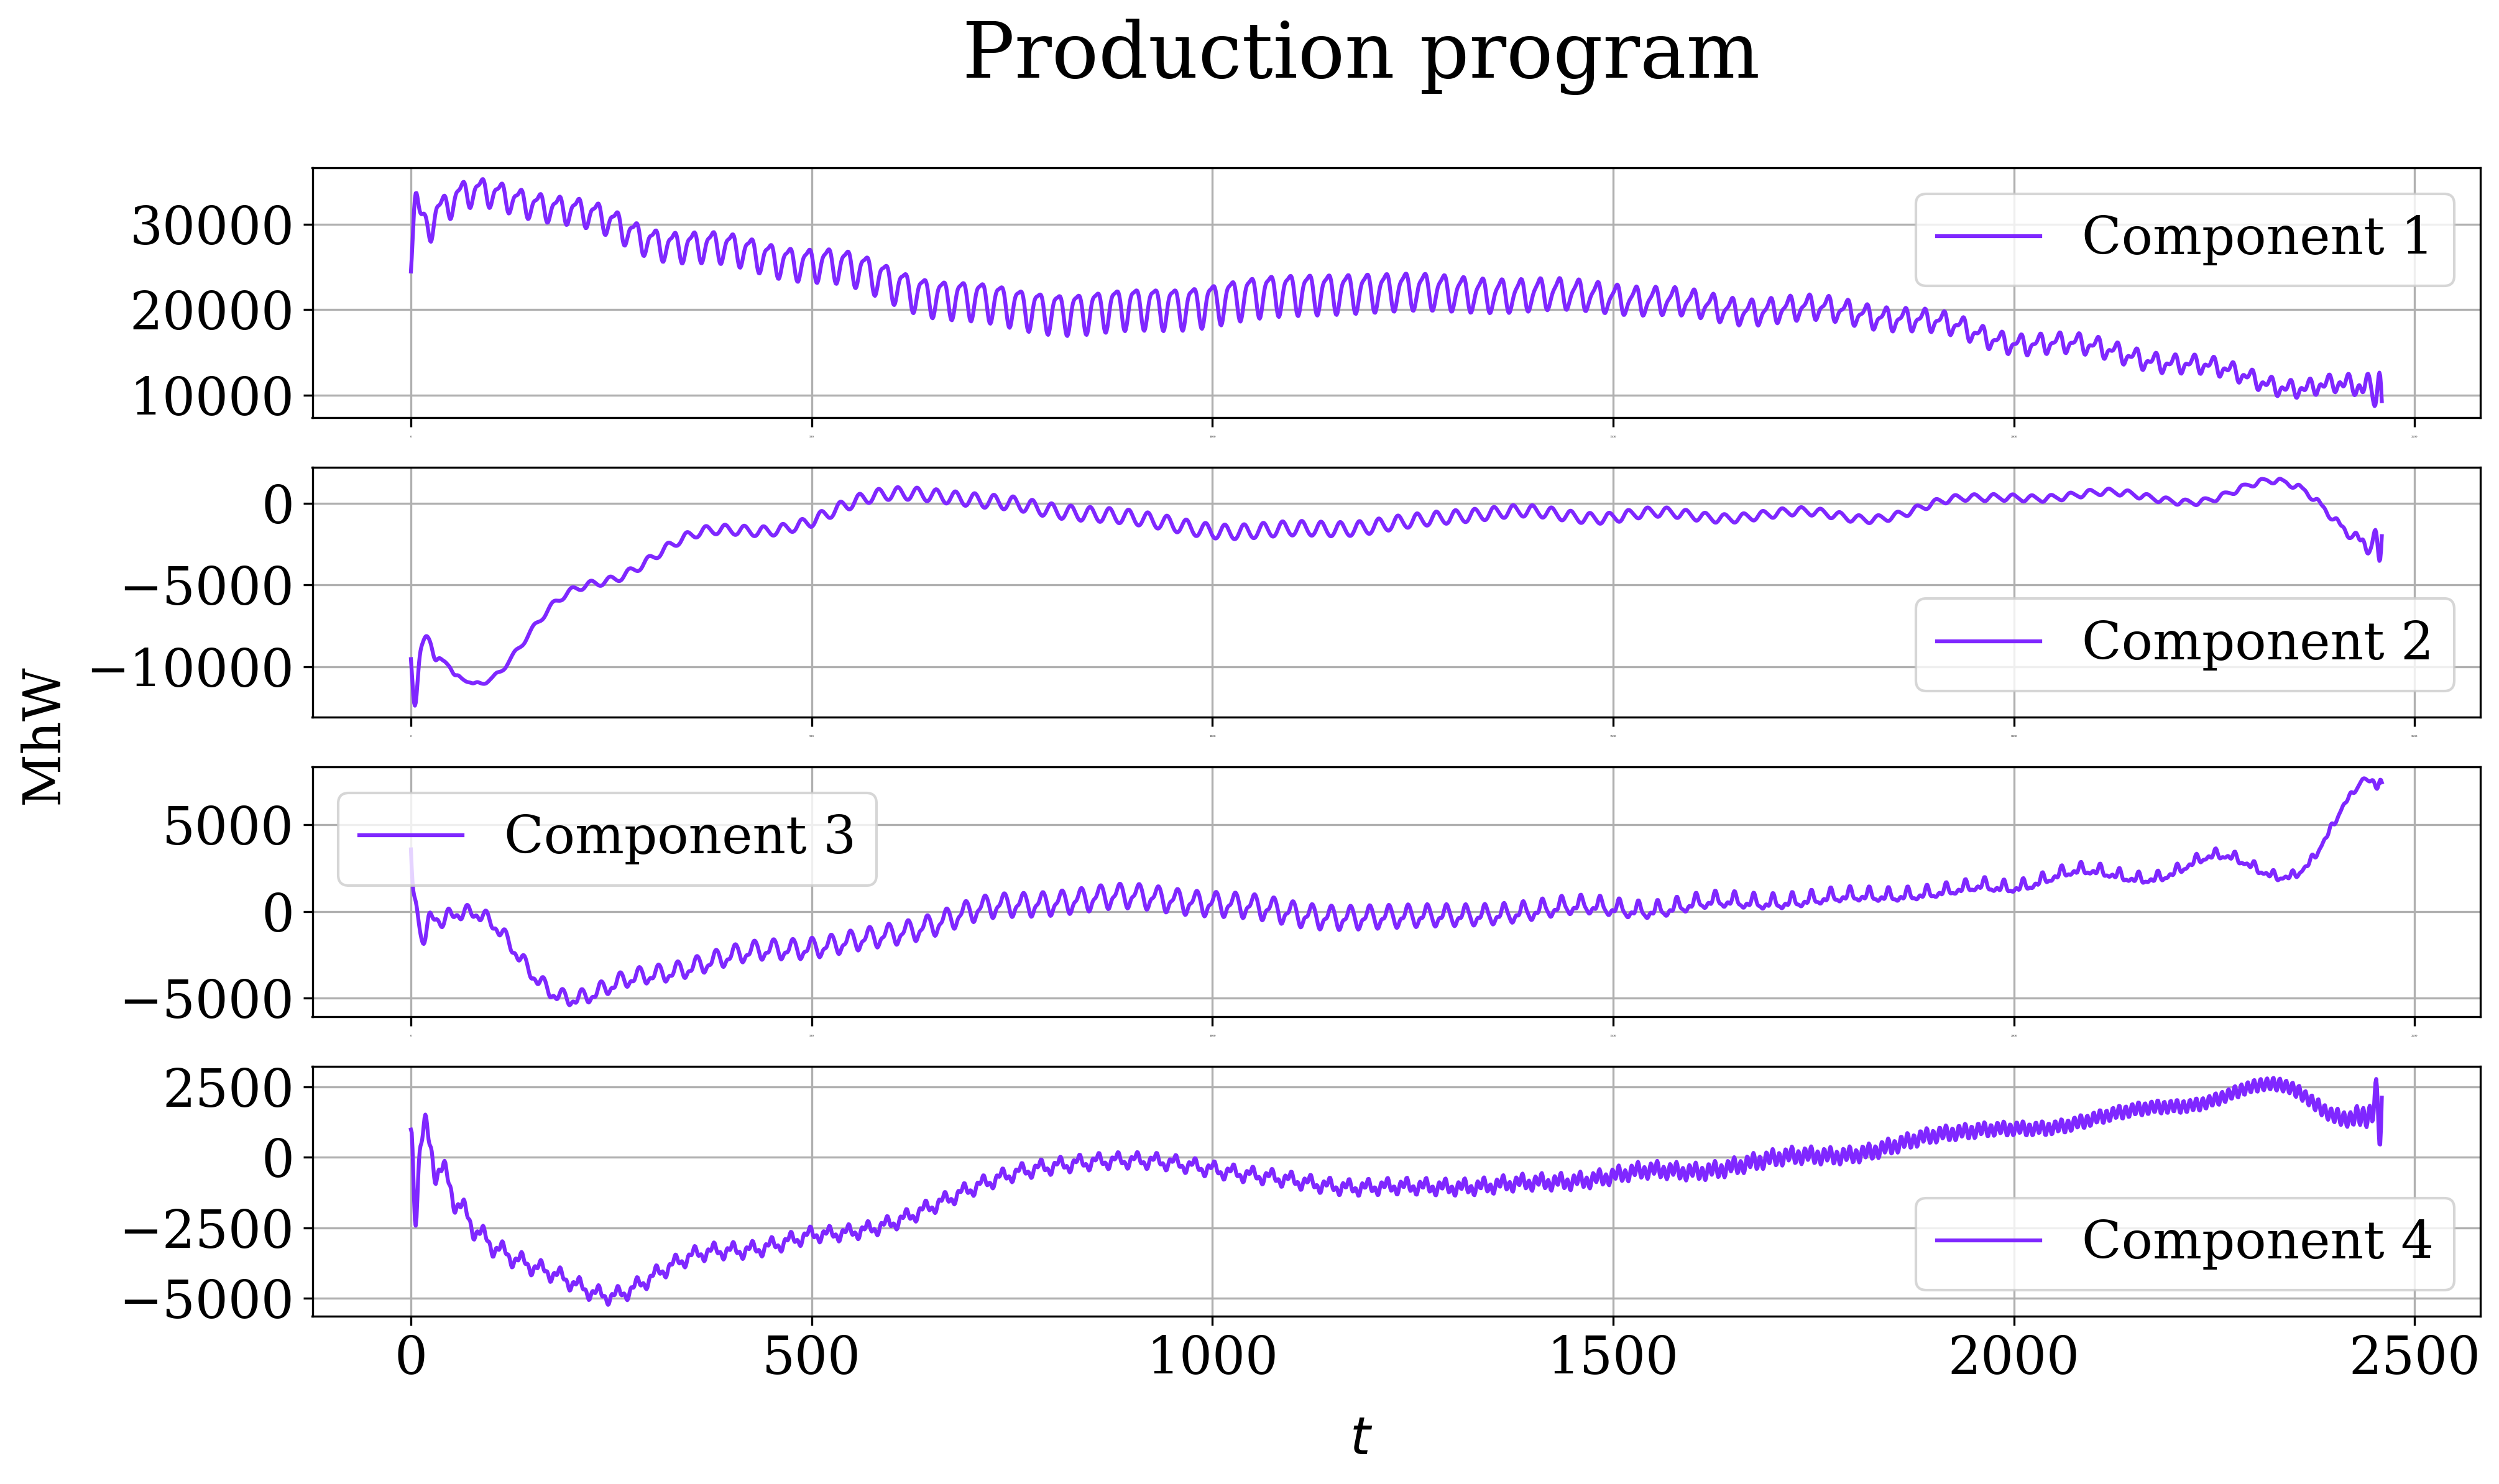

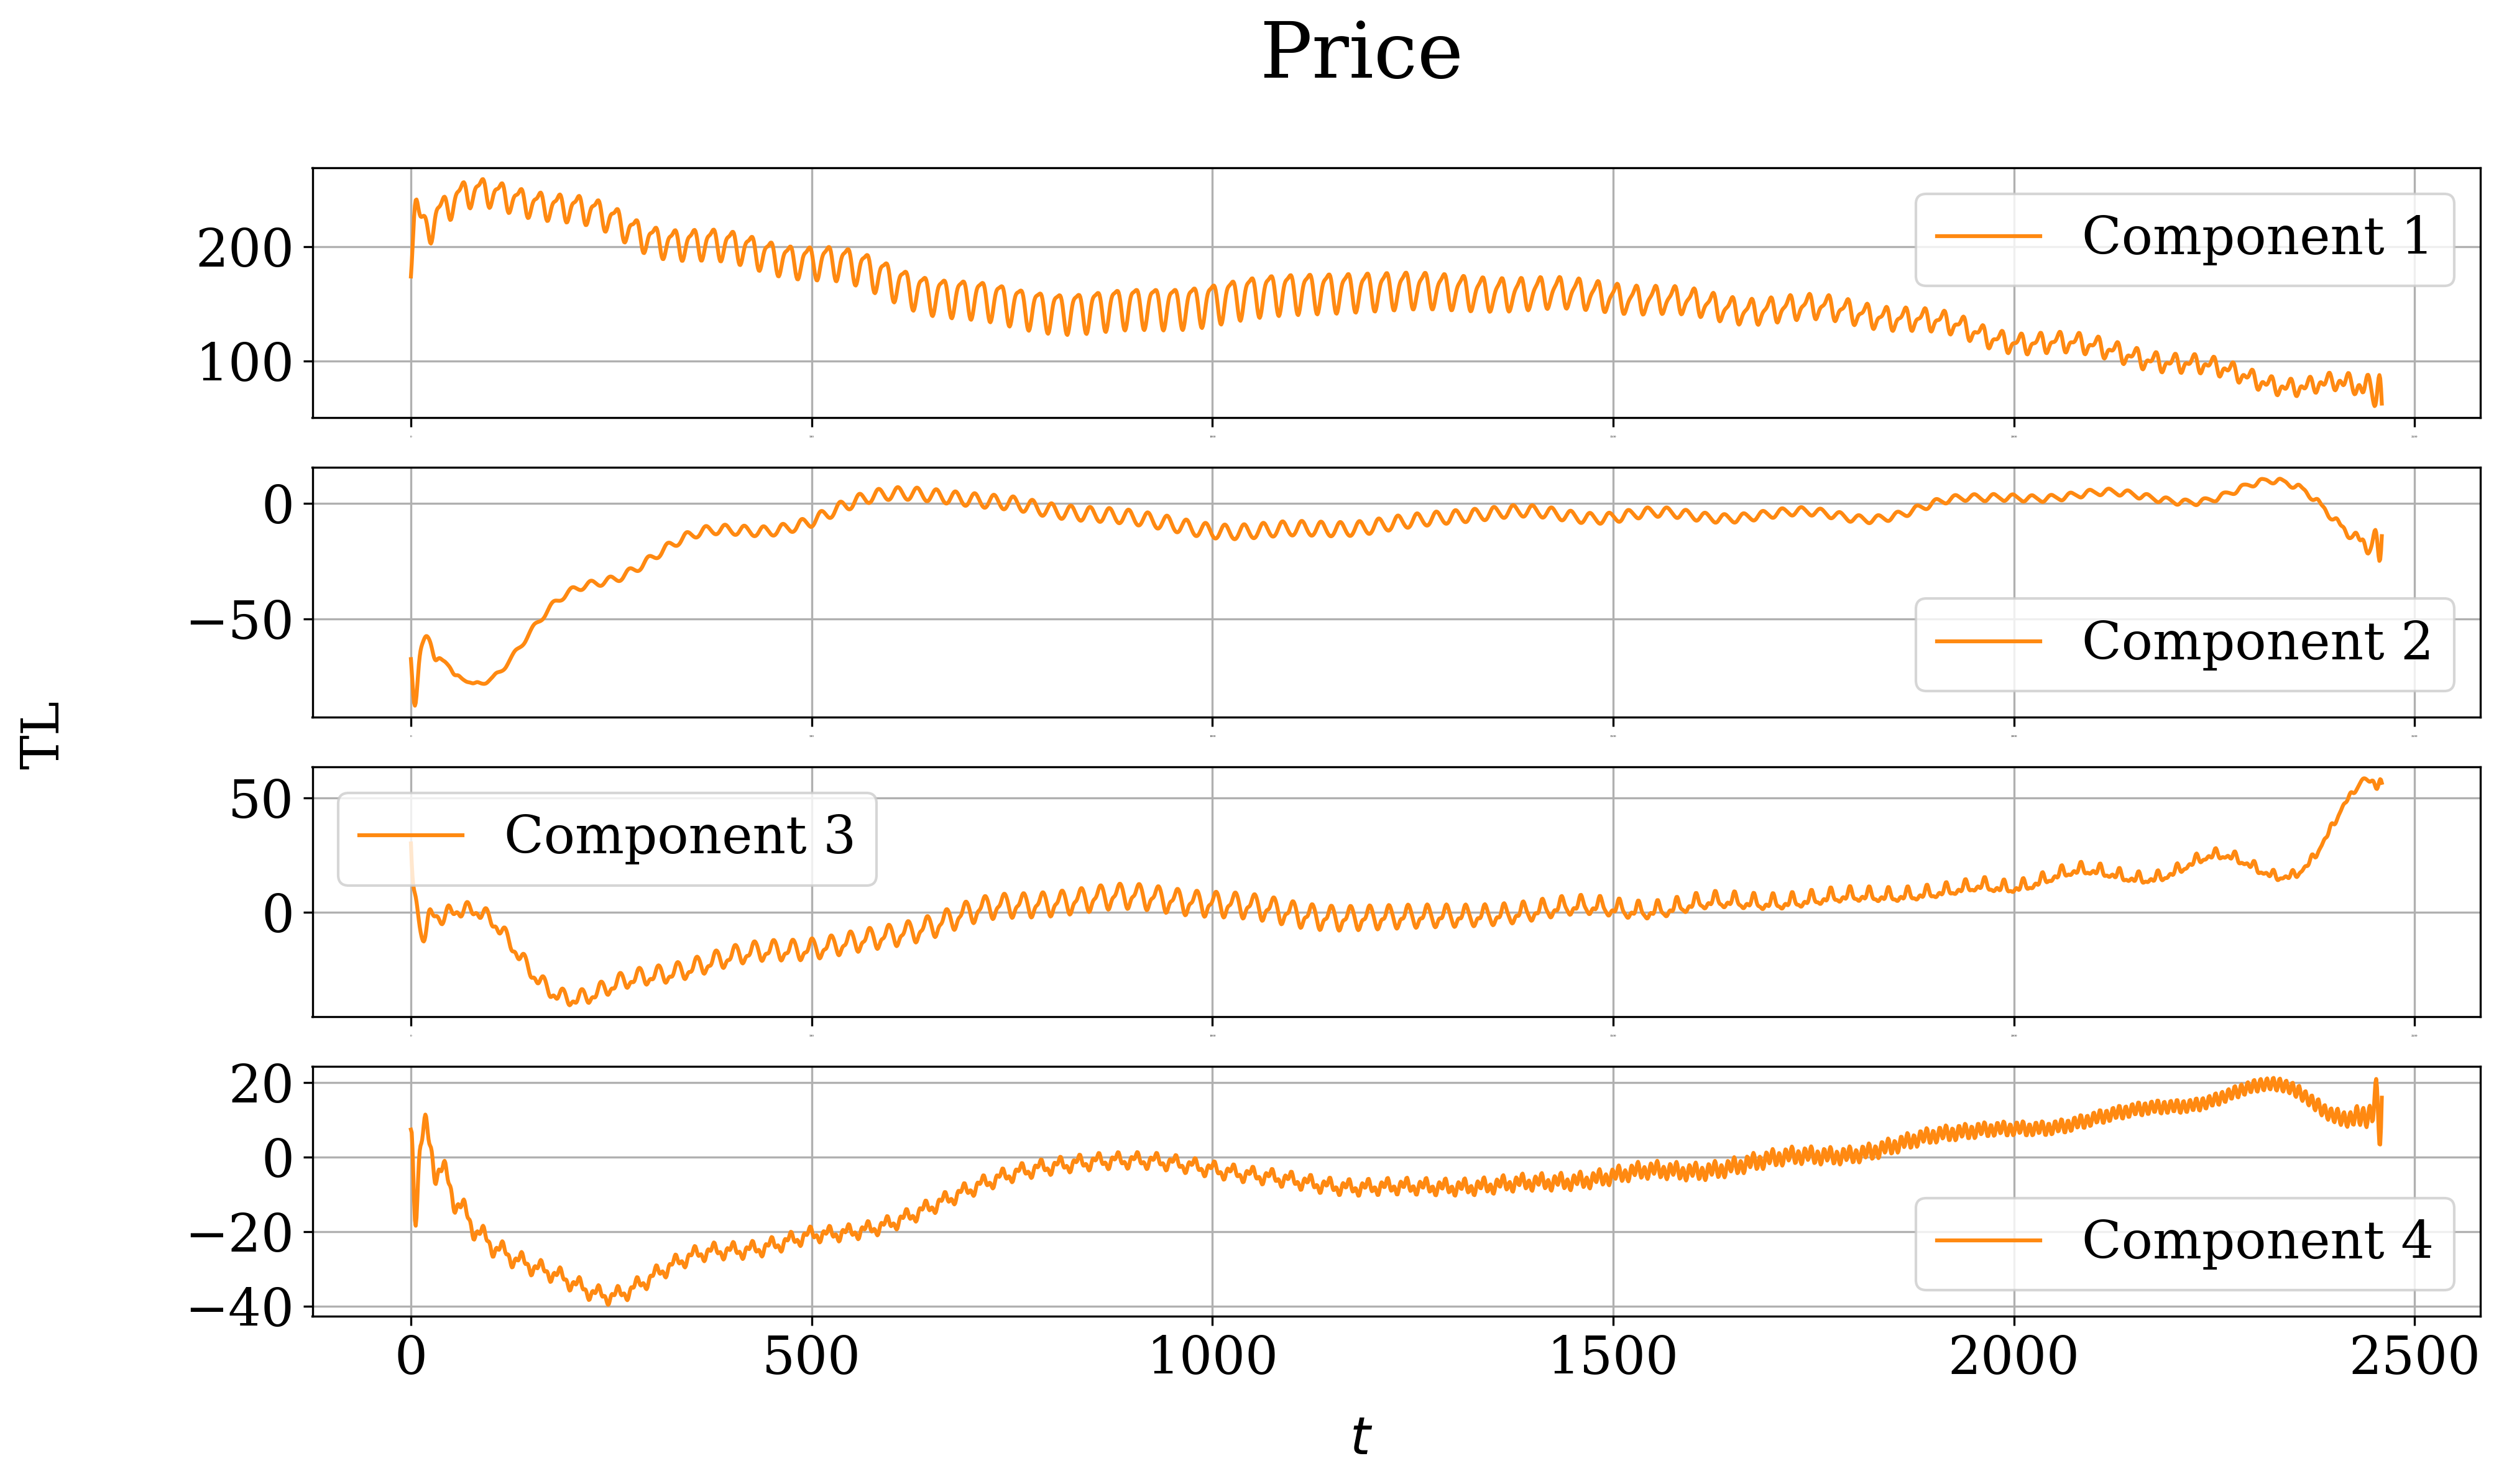

In [16]:
# use generator
if want_to_disect:
    # execute this cell as many times as needed changing 'groups_to_disect'
    # this is the list of groups to futher disect for each signal
    
    # disect chosen groups into two more
    groups_to_disect = [[0], [0]]
    # enter unique grouping id (not 1)
    grouping_id = 3
    
    if (groups_to_disect is not None) and (grouping_id is not None):
        dichy_groups, dichy_hankel_resids = DichPartitionGenerator.send(groups_to_disect)

        # save generated grouping
        with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{grouping_id}.pkl', 'wb') as f:
            pickle.dump(dichy_groups, f)
    
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_{grouping_id}').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_{grouping_id}/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )

## Prediction

In [20]:
# make directory for figures
pathlib.Path(f'./figs/prediction/cpd_rank_{cpd_rank}').mkdir(parents=True, exist_ok=True)

In [22]:
t_ssa_obj.remove_last_predictions()

# get prediction for cuurent number of factors left
forecast_tssa = np.empty(test_data.shape)

for i in range(test_data.shape[0]):
    forecast_tssa[i] = np.array(t_ssa_obj.predict_next())

# get MSE for every signal
signals_mse_tssa = np.mean((forecast_tssa - test_data) ** 2, axis=0)
# get MAPE for every signal
signals_mape_tssa = np.mean(np.abs((forecast_tssa - test_data) / test_data), axis=0)

print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa)}')

MSE: [1.56882242e+06 1.03314127e+03]; Mean by signals = 7.849278e+05
MAPE: [0.05963761 0.17744386]; Mean by signals = 0.11854073465443365


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


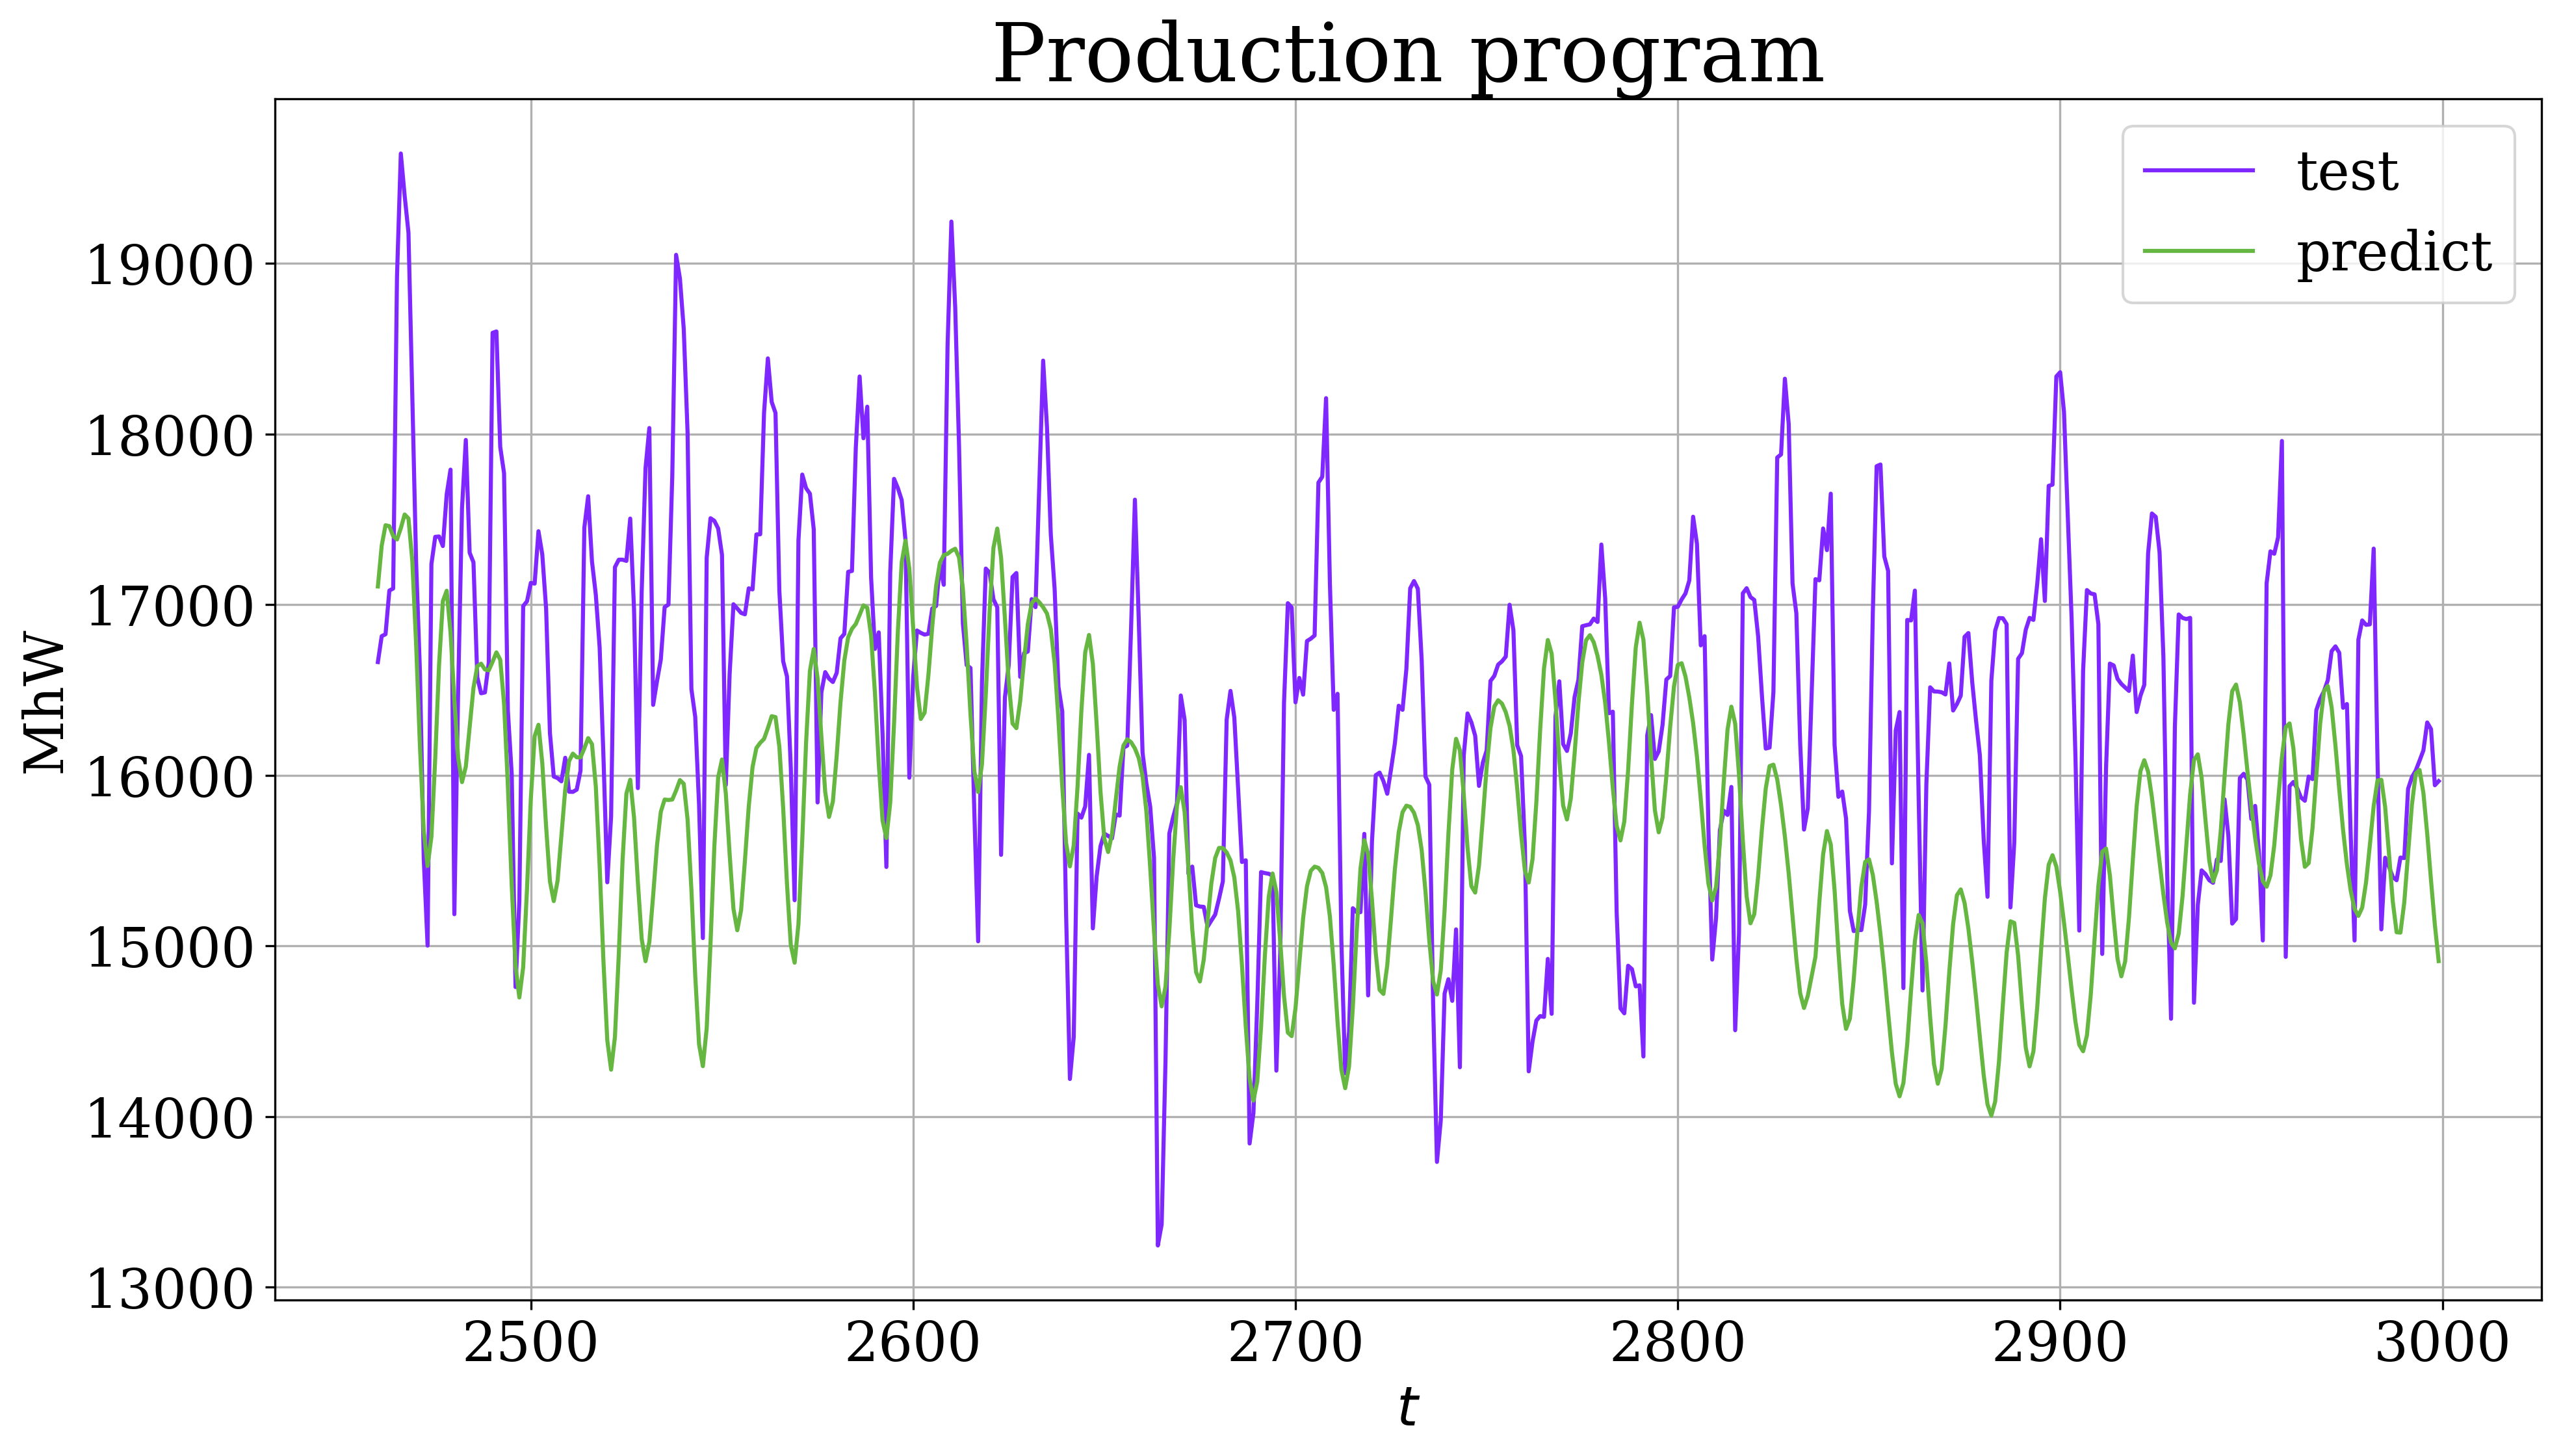

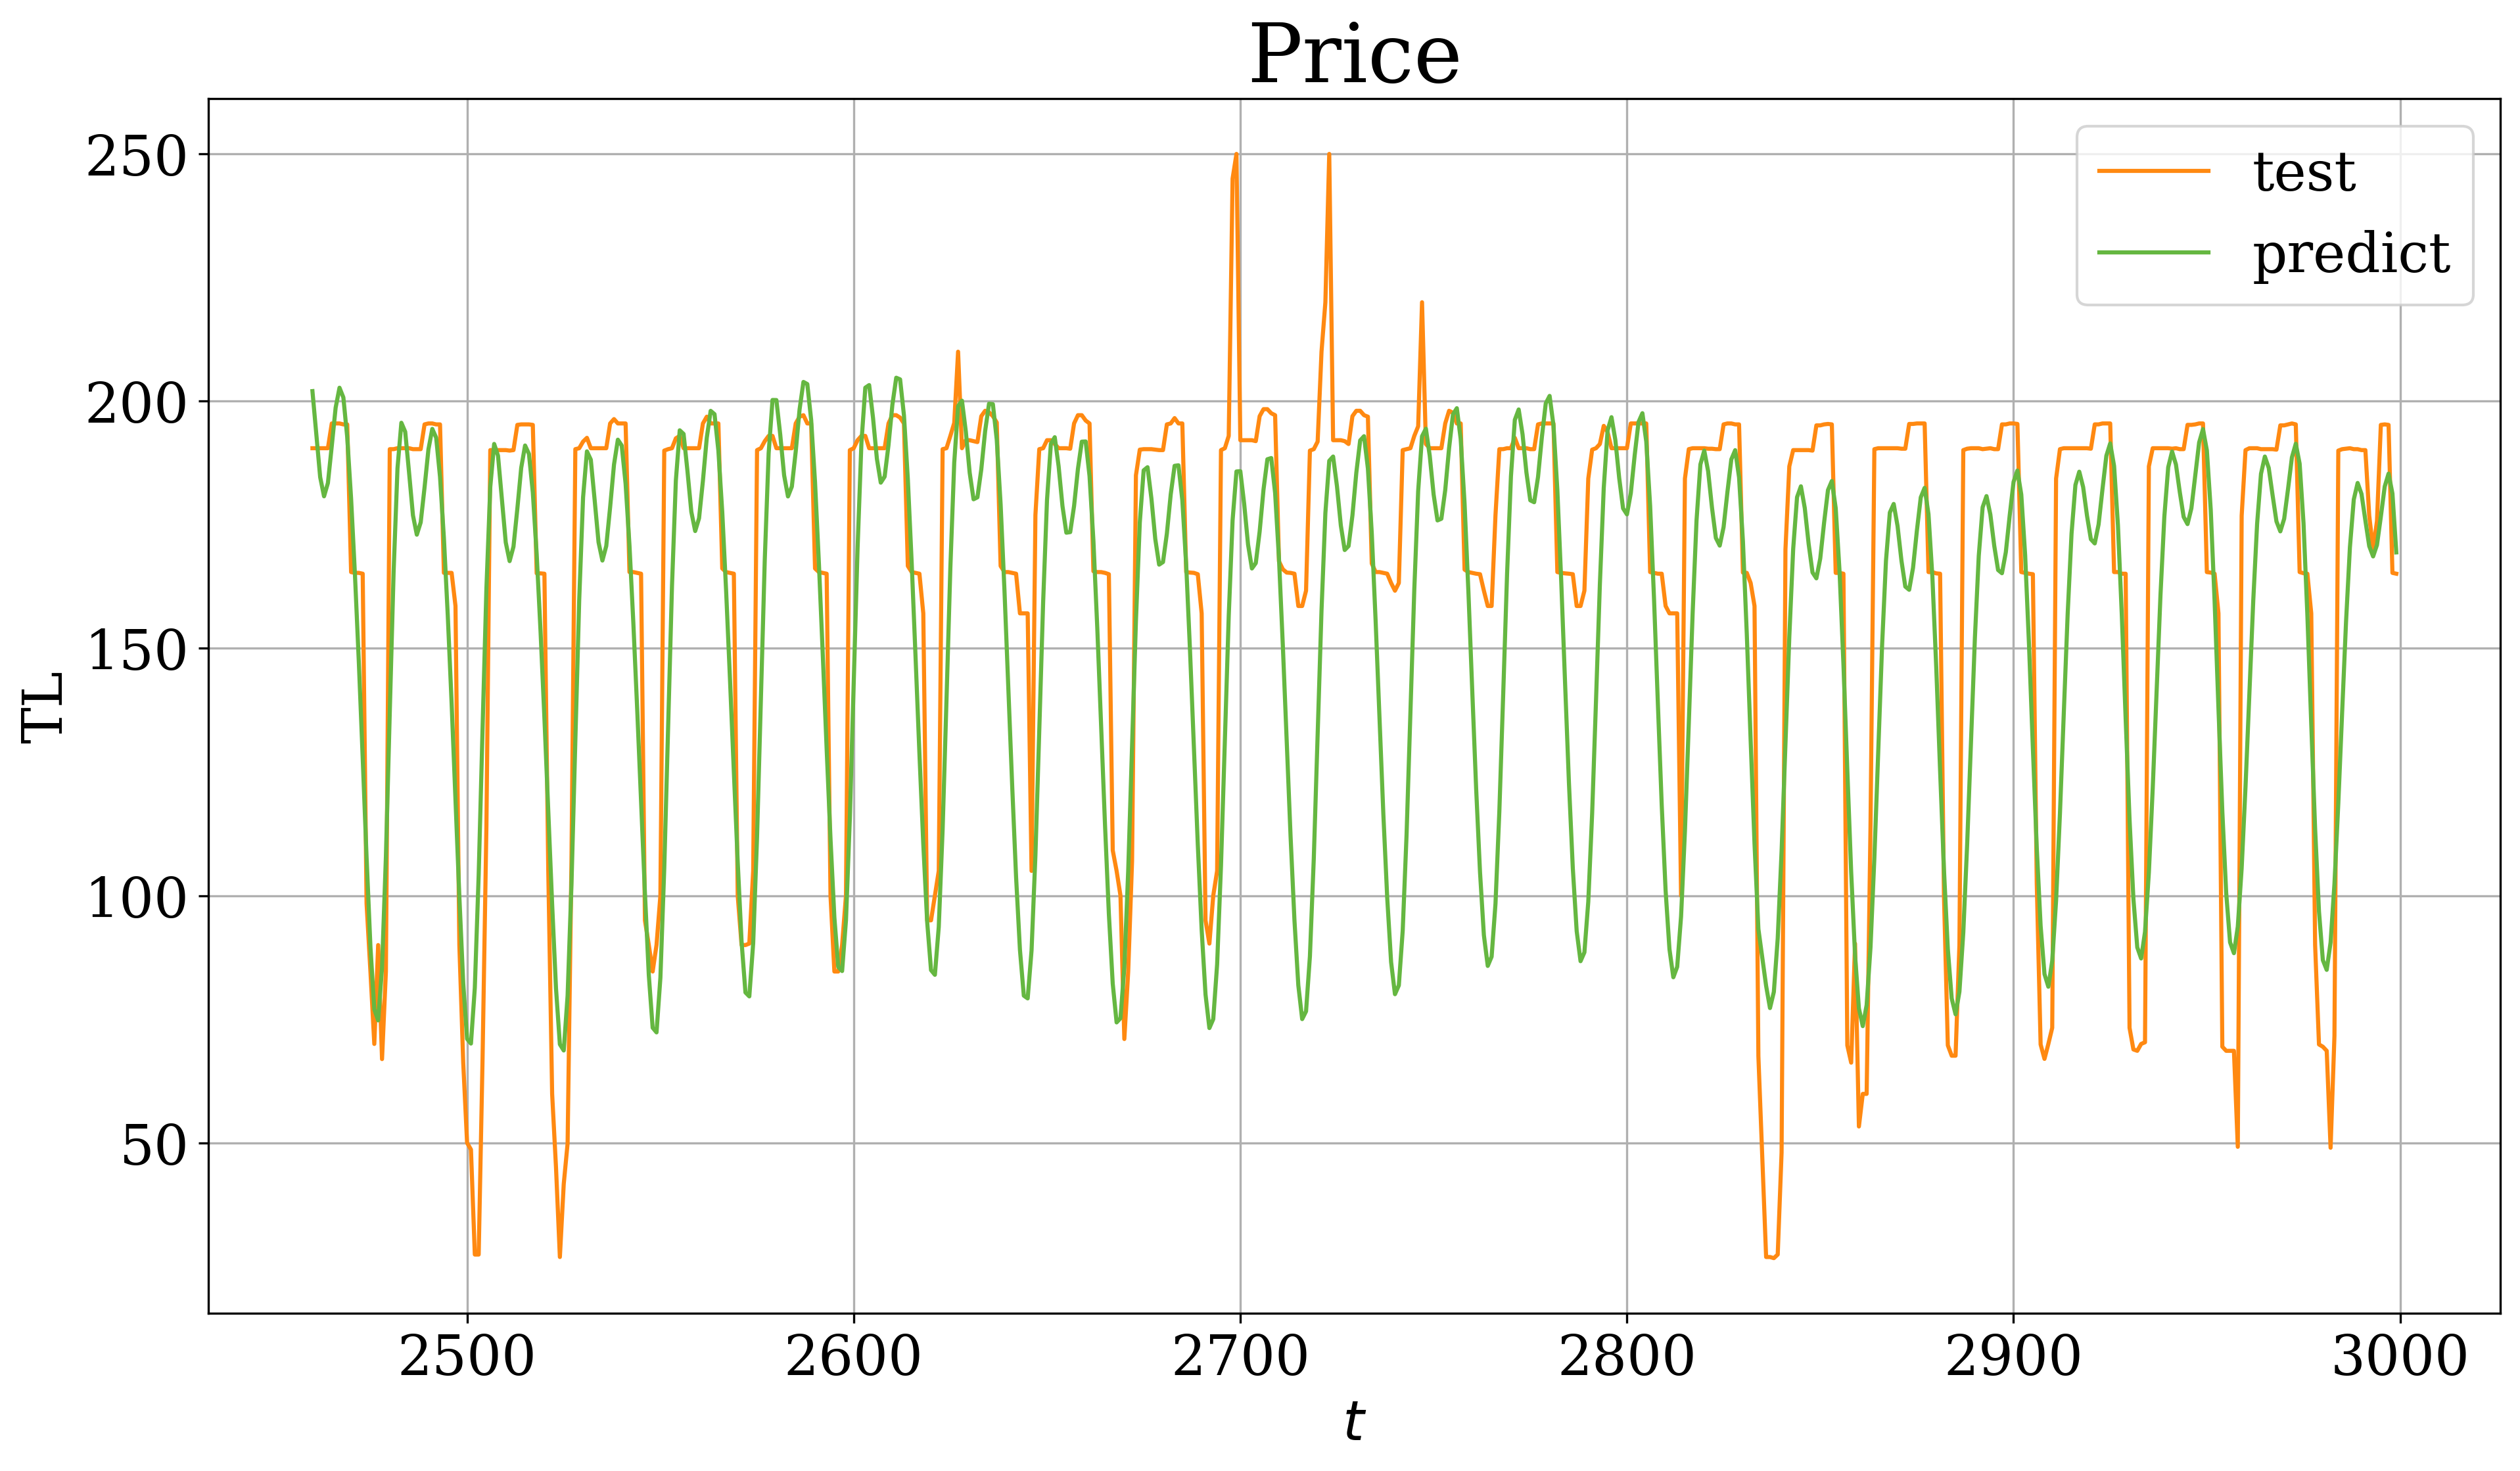

In [23]:
# plot prediction and real values
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, forecast_tssa.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/cpd_rank_{cpd_rank}/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')